In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#Kebutuhan Elektrifikasi

In [ ]:


penduduk_2022 = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/Penduduk.csv')
penduduk_2022.head()

Provinsi    Total
0            ACEH  1282832
1  SUMATERA UTARA  3527273
2  SUMATERA BARAT  1337791
3            RIAU  1586498
4           JAMBI   903600

In [ ]:
presentase = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/download/Persentase Rumah Tangga menurut Provinsi dan Sumber Penerangan Utama dari Listrik, 2020-2022.xlsx - Sheet1.csv', decimal=',')
presentase.head()

Provinsi   2020   2021   2022
0            ACEH  99.65  99.87  99.84
1  SUMATERA UTARA  98.72  99.16  99.49
2  SUMATERA BARAT  99.05  98.86  99.52
3            RIAU  98.83  98.32  99.13
4           JAMBI  98.74  99.03  99.43

In [ ]:
# Retry converting the '2022' column by first converting all values to string, replacing commas, and then to float.
presentase['2022'] = presentase['2022'].astype(str).str.replace(',', '.').astype(float)

# Merge the dataframes on 'Provinsi' again
merged_df = pd.merge(penduduk_2022, presentase[['Provinsi', '2022']], on='Provinsi', how='inner')


merged_df.head()

Provinsi    Total   2022
0            ACEH  1282832  99.84
1  SUMATERA UTARA  3527273  99.49
2  SUMATERA BARAT  1337791  99.52
3            RIAU  1586498  99.13
4           JAMBI   903600  99.43

In [ ]:


merged_df = merged_df[merged_df['Provinsi'] != 'INDONESIA']

In [ ]:


merged_df['Need Index'] = (1 - (merged_df['2022'] / 100)) * merged_df['Total']
merged_df.head()


Provinsi    Total   2022  Need Index
0            ACEH  1282832  99.84   2052.5312
1  SUMATERA UTARA  3527273  99.49  17989.0923
2  SUMATERA BARAT  1337791  99.52   6421.3968
3            RIAU  1586498  99.13  13802.5326
4           JAMBI   903600  99.43   5150.5200

In [ ]:


top_5_provinsi = merged_df.sort_values('Need Index', ascending=False).head(5)
print(top_5_provinsi[['Provinsi', '2022', 'Need Index']])


               Provinsi   2022   Need Index
33                PAPUA  79.96  206140.0572
18  NUSA TENGGARA TIMUR  94.87   60700.7763
19     KALIMANTAN BARAT  97.02   38371.8210
1        SUMATERA UTARA  99.49   17989.0923
30               MALUKU  96.36   14103.6532


# Sektor Distribusi Listrik di Indonesia

In [ ]:
data_sector = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/Listrik Yang Didistribusikan Kepada Pelanggan (GWh).csv', on_bad_lines='skip', engine='python', na_values=['-'], decimal=',')
data_sector

Kelompok Pelanggan - PLN       2011       2012       2013       2014  \
0                   Sosial    3998.01    4447.45    4873.11    5446.61   
1             Rumah Tangga   65146.28   72176.80   77869.29   84136.25   
2                   Bisnis   28317.30   30689.44   33748.61   36289.01   
3                 Industri   55377.49   60828.60   65255.61   66277.86   
4                   Publik    5855.82    6199.62    6595.80    6878.35   
5          Semua Pelanggan  158694.90  174341.91  188342.41  199028.08   

        2015       2017       2018       2019       2020       2021       2022  
0    5946.47    7055.32    7789.35    8627.46    8050.55    8665.99   10073.23  
1   88742.25   93733.71   97930.90  103789.68  111413.28  115370.05  116095.41  
2   36994.66   41625.37   44049.88   46905.74   42182.71   44440.85   50532.19  
3   65429.77   75970.15   81109.52   79932.93   71521.43   80904.45   88483.30  
4    7166.83    7629.51    8132.39    8397.52    8237.63    8252.92    8577.35  
5  204279.97  226014.06  239012.04  247653.33  241405.60  257634.26  273761.48

In [ ]:
data_sector = data_sector.drop(5)
data_sector

Kelompok Pelanggan - PLN      2011      2012      2013      2014      2015  \
0                   Sosial   3998.01   4447.45   4873.11   5446.61   5946.47   
1             Rumah Tangga  65146.28  72176.80  77869.29  84136.25  88742.25   
2                   Bisnis  28317.30  30689.44  33748.61  36289.01  36994.66   
3                 Industri  55377.49  60828.60  65255.61  66277.86  65429.77   
4                   Publik   5855.82   6199.62   6595.80   6878.35   7166.83   

       2017      2018       2019       2020       2021       2022  
0   7055.32   7789.35    8627.46    8050.55    8665.99   10073.23  
1  93733.71  97930.90  103789.68  111413.28  115370.05  116095.41  
2  41625.37  44049.88   46905.74   42182.71   44440.85   50532.19  
3  75970.15  81109.52   79932.93   71521.43   80904.45   88483.30  
4   7629.51   8132.39    8397.52    8237.63    8252.92    8577.35

## EDA

In [ ]:
data_sector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Kelompok Pelanggan - PLN  5 non-null      object 
 1   2011                      5 non-null      float64
 2   2012                      5 non-null      float64
 3   2013                      5 non-null      float64
 4   2014                      5 non-null      float64
 5   2015                      5 non-null      float64
 6   2017                      5 non-null      float64
 7   2018                      5 non-null      float64
 8   2019                      5 non-null      float64
 9   2020                      5 non-null      float64
 10  2021                      5 non-null      float64
 11  2022                      5 non-null      float64
dtypes: float64(11), object(1)
memory usage: 608.0+ bytes


In [ ]:
data_sector.describe()

2011          2012          2013          2014          2015  \
count      5.000000      5.000000      5.000000      5.000000      5.000000   
mean   31738.980000  34868.382000  37668.484000  39805.616000  40855.996000   
std    27955.474108  30946.104548  33292.521619  35153.582572  36281.911877   
min     3998.010000   4447.450000   4873.110000   5446.610000   5946.470000   
25%     5855.820000   6199.620000   6595.800000   6878.350000   7166.830000   
50%    28317.300000  30689.440000  33748.610000  36289.010000  36994.660000   
75%    55377.490000  60828.600000  65255.610000  66277.860000  65429.770000   
max    65146.280000  72176.800000  77869.290000  84136.250000  88742.250000   

               2017          2018           2019          2020           2021  \
count      5.000000      5.000000       5.000000       5.00000       5.000000   
mean   45202.812000  47802.408000   49530.666000   48281.12000   51526.852000   
std    39311.764806  41264.591434   42544.789499   44116.18777   46633.934269   
min     7055.320000   7789.350000    8397.520000    8050.55000    8252.920000   
25%     7629.510000   8132.390000    8627.460000    8237.63000    8665.990000   
50%    41625.370000  44049.880000   46905.740000   42182.71000   44440.850000   
75%    75970.150000  81109.520000   79932.930000   71521.43000   80904.450000   
max    93733.710000  97930.900000  103789.680000  111413.28000  115370.050000   

                2022  
count       5.000000  
mean    54752.296000  
std     47557.628561  
min      8577.350000  
25%     10073.230000  
50%     50532.190000  
75%     88483.300000  
max    116095.410000

In [ ]:
data_sector.isna().any()

Kelompok Pelanggan - PLN    False
2011                        False
2012                        False
2013                        False
2014                        False
2015                        False
2017                        False
2018                        False
2019                        False
2020                        False
2021                        False
2022                        False
dtype: bool

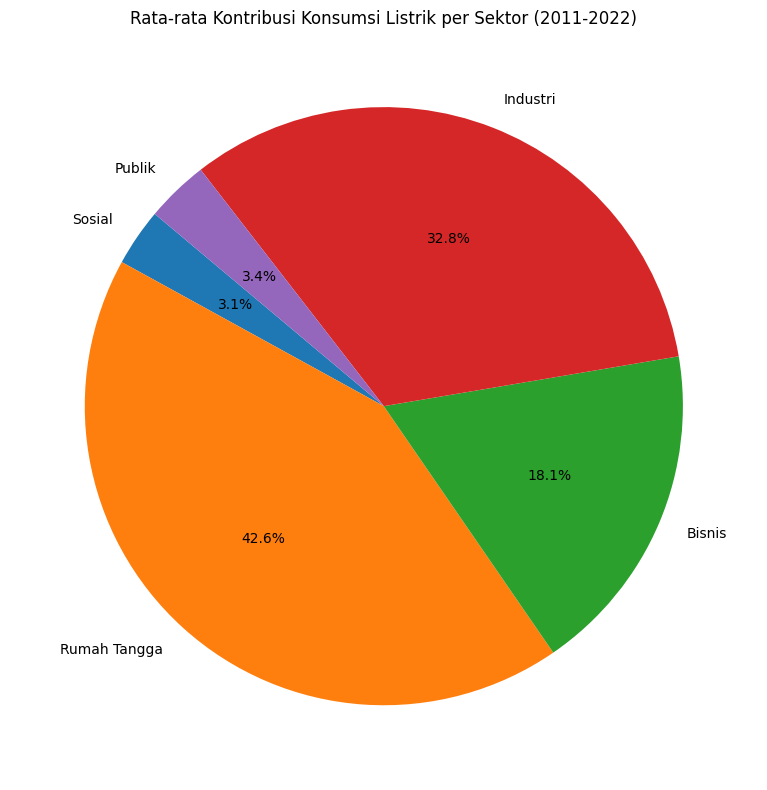

In [ ]:
# Calculating the average consumption per sector over the available years for a comprehensive view
average_consumption = data_sector.iloc[:, 1:].mean(axis=1)

# Creating a pie chart to visualize the contribution of each sector to the total electricity consumption
plt.figure(figsize=(8, 8))
plt.pie(average_consumption, labels=data_sector['Kelompok Pelanggan - PLN'], autopct='%1.1f%%', startangle=140)

# Adding title
plt.title('Rata-rata Kontribusi Konsumsi Listrik per Sektor (2011-2022)')
plt.tight_layout()

# Show plot
plt.show()

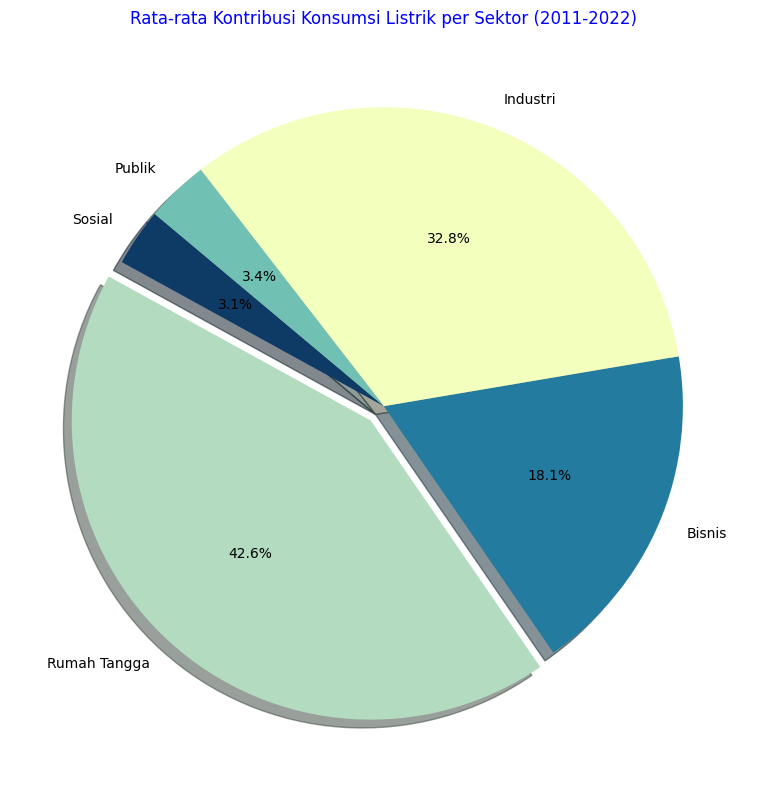

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Hitung konsumsi rata-rata per sektor (kecuali kolom pertama yang berisi nama sektor)
average_consumption = data_sector.iloc[:, 1:].mean(axis=1)
colors = [  '#0D3B66', '#B2DBBF', '#247BA0','#F3FFBD', '#70C1B3']
explode = [0.065 if sektor == 'Rumah Tangga' else 0 for sektor in data_sector['Kelompok Pelanggan - PLN']]

# Create pie chart with 3D effect using explode
plt.figure(figsize=(8, 8))
plt.pie(average_consumption, labels=data_sector['Kelompok Pelanggan - PLN'], autopct='%1.1f%%', startangle=140,
        colors=colors, explode=explode, shadow=True)

# Adding title
plt.title('Rata-rata Kontribusi Konsumsi Listrik per Sektor (2011-2022)', color='blue')

# Show plot
plt.tight_layout()
plt.show()


# Data Distribusi Listrik

In [ ]:
distribusi = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/Listrik yang Didistribusikan Menurut Provinsi (GWh).csv', on_bad_lines='skip', engine='python', na_values=['-'], decimal=',')
distribusi

Provinsi       2011       2012       2013       2014  \
0                        Aceh    1579.77    1755.06    1815.04    1965.55   
1              Sumatera Utara    7194.03    7809.32    7917.24    8271.01   
2              Sumatera Barat    2403.10    2649.08    2712.85    3005.26   
3                        Riau    2361.15    2723.81    3597.44    3338.33   
4                       Jambi    1054.17     860.39     955.66    1037.45   
5            Sumatera Selatan    2978.86    3863.12    4162.09    4477.49   
6                    Bengkulu     493.95     566.95     641.52     729.64   
7                     Lampung    2425.94    2793.36    3182.21    3392.44   
8   Kepulauan Bangka Belitung     535.61     664.72     721.24     805.43   
9              Kepulauan Riau    2010.30    2190.04    2421.92    2618.48   
10                Dki Jakarta   35061.38   38168.75   39937.28   41269.03   
11                 Jawa Barat   34053.60   36655.28   39092.56   43096.46   
12                Jawa Tengah   15315.89   16600.42   18205.08   19631.46   
13              Di Yogyakarta    1869.77    2043.75    2205.79    2369.60   
14                 Jawa Timur   24018.69   26910.18   28708.11   30523.98   
15                     Banten    7955.54    8457.80    9750.37    8562.97   
16                       Bali    3223.94    3546.60    3914.32    4335.03   
17        Nusa Tenggara Barat     837.17     976.39    1133.33    1291.47   
18        Nusa Tenggara Timur     486.91     567.32     639.57     702.26   
19           Kalimantan Barat    1434.72    1603.72    1889.39    1862.44   
20          Kalimantan Tengah     649.95     752.34     854.78     970.16   
21         Kalimantan Selatan    1467.13    1688.44    1880.66    2092.23   
22           Kalimantan Timur    2277.22    2502.32    2731.58    2815.55   
23           Kalimantan Utara        NaN        NaN     180.73     199.37   
24             Sulawesi Utara     986.62    1087.08    1192.52    1240.32   
25            Sulawesi Tengah     574.71     686.19     758.70     865.77   
26           Sulawesi Selatan    3246.42    3639.63    4156.49    4339.22   
27          Sulawesi Tenggara     441.08     528.42     621.64     670.71   
28                  Gorontalo     236.52     293.13     328.40     366.08   
29             Sulawesi Barat     151.52     177.63     207.59     238.03   
30                     Maluku     336.69     397.49     469.96     480.08   
31               Maluku Utara     204.67     235.88     259.10     309.37   
32                Papua Barat     305.08     346.65     383.99     430.63   
33                      Papua     522.80     600.67     713.26     724.78   
34                  Indonesia  158694.89  174341.92  188342.41  199028.08   

         2015       2017       2018       2019       2020       2021  \
0     2119.00    2409.11    2587.71    2781.50    2937.99    3074.47   
1     8703.67    9671.48   10445.02    8324.86   11192.85   11748.40   
2     3063.28    3415.29    3496.18    3445.08    3429.29    3646.20   
3     3586.45    4069.93    4377.21    4646.79    4967.05    6108.32   
4     1083.79    1176.09    1219.01    1932.00    2010.60    2111.92   
5     4783.02    5239.35    5501.26    5258.23    5312.77    5593.93   
6      785.43     852.84     907.45     955.47    1013.50    1058.61   
7     3571.00    3998.30    4257.15    4686.09    4959.02    5176.94   
8      861.52     979.19    1066.35    1166.93    1217.52    1369.20   
9     2694.79    2823.17    2990.44    3346.31     887.60    3478.63   
10   41328.60   31643.13   32779.19   34107.88   32166.72   32709.30   
11   44071.43   50791.20   52878.86   54480.28   49542.25   53318.02   
12   20408.19   21057.04   23558.02   24750.62   25090.74   26661.16   
13    2484.16    2724.49    2856.95    2856.95    3012.45    3108.38   
14   30824.81   34114.16   35817.90   37228.94   37613.55   39457.19   
15    8575.10   22557.53   23736.30   24646.11   22268.71   23830.91   
16    4594.18    5069.64

In [ ]:
distribusi = distribusi.drop(34)
distribusi

Provinsi      2011      2012      2013      2014  \
0                        Aceh   1579.77   1755.06   1815.04   1965.55   
1              Sumatera Utara   7194.03   7809.32   7917.24   8271.01   
2              Sumatera Barat   2403.10   2649.08   2712.85   3005.26   
3                        Riau   2361.15   2723.81   3597.44   3338.33   
4                       Jambi   1054.17    860.39    955.66   1037.45   
5            Sumatera Selatan   2978.86   3863.12   4162.09   4477.49   
6                    Bengkulu    493.95    566.95    641.52    729.64   
7                     Lampung   2425.94   2793.36   3182.21   3392.44   
8   Kepulauan Bangka Belitung    535.61    664.72    721.24    805.43   
9              Kepulauan Riau   2010.30   2190.04   2421.92   2618.48   
10                Dki Jakarta  35061.38  38168.75  39937.28  41269.03   
11                 Jawa Barat  34053.60  36655.28  39092.56  43096.46   
12                Jawa Tengah  15315.89  16600.42  18205.08  19631.46   
13              Di Yogyakarta   1869.77   2043.75   2205.79   2369.60   
14                 Jawa Timur  24018.69  26910.18  28708.11  30523.98   
15                     Banten   7955.54   8457.80   9750.37   8562.97   
16                       Bali   3223.94   3546.60   3914.32   4335.03   
17        Nusa Tenggara Barat    837.17    976.39   1133.33   1291.47   
18        Nusa Tenggara Timur    486.91    567.32    639.57    702.26   
19           Kalimantan Barat   1434.72   1603.72   1889.39   1862.44   
20          Kalimantan Tengah    649.95    752.34    854.78    970.16   
21         Kalimantan Selatan   1467.13   1688.44   1880.66   2092.23   
22           Kalimantan Timur   2277.22   2502.32   2731.58   2815.55   
23           Kalimantan Utara       NaN       NaN    180.73    199.37   
24             Sulawesi Utara    986.62   1087.08   1192.52   1240.32   
25            Sulawesi Tengah    574.71    686.19    758.70    865.77   
26           Sulawesi Selatan   3246.42   3639.63   4156.49   4339.22   
27          Sulawesi Tenggara    441.08    528.42    621.64    670.71   
28                  Gorontalo    236.52    293.13    328.40    366.08   
29             Sulawesi Barat    151.52    177.63    207.59    238.03   
30                     Maluku    336.69    397.49    469.96    480.08   
31               Maluku Utara    204.67    235.88    259.10    309.37   
32                Papua Barat    305.08    346.65    383.99    430.63   
33                      Papua    522.80    600.67    713.26    724.78   

        2015      2017      2018      2019      2020      2021      2022  
0    2119.00   2409.11   2587.71   2781.50   2937.99   3074.47   3154.01  
1    8703.67   9671.48  10445.02   8324.86  11192.85  11748.40  12059.81  
2    3063.28   3415.29   3496.18   3445.08   3429.29   3646.20   3630.43  
3    3586.45   4069.93   4377.21   4646.79   4967.05   6108.32   7691.64  
4    1083.79   1176.09   1219.01   1932.00   2010.60   2111.92   2234.86  
5    4783.02   5239.35   5501.26   5258.23   5312.77   5593.93   5878.31  
6     785.43    852.84    907.45    955.47   1013.50   1058.61   1087.22  
7    3571.00   3998.30   4257.15   4686.09   4959.02   5176.94   5382.48  
8     861.52    979.19   1066.35   1166.93   1217.52   1369.20   1484.13  
9    2694.79   2823.17   2990.44   3346.31    887.60   3478.63   3889.72  
10  41328.60  31643.13  32779.19  34107.88  32166.72  32709.30  34578.29  
11  44071.43  50791.20  52878.86  54480.28  49542.25  53318.02  56226.11  
12  20408.19  21057.04  23558.02  24750.62  25090.74  26661.16  27564.64  
13   2484.16   2724.49   2856.95   2856.95   3012.45   3108.38   3326.61  
14  30824.81  34114.16  35817.90  37228.94  37613.55  39457.19  40546.88  
15   8575.10  22557.53  23736.30  24646.11  22268.71  23830.91  26705.67  
16   4594.18   5069.64   5247.16   5706.73   4946.86   4708.02   5470.51  
17   1402.30   1677.54   1776.81   1950.25   2149.42   2290.19   2359.31  
18    749.76    855.25    927.41    999.

## EDA

In [ ]:
distribusi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Provinsi  34 non-null     object 
 1   2011      33 non-null     float64
 2   2012      33 non-null     float64
 3   2013      34 non-null     float64
 4   2014      34 non-null     float64
 5   2015      34 non-null     float64
 6   2017      34 non-null     float64
 7   2018      34 non-null     float64
 8   2019      34 non-null     float64
 9   2020      34 non-null     float64
 10  2021      34 non-null     float64
 11  2022      34 non-null     float64
dtypes: float64(11), object(1)
memory usage: 3.3+ KB


In [ ]:
distribusi.describe()

2011          2012          2013          2014          2015  \
count     33.000000     33.000000     34.000000     34.000000     34.000000   
mean    4808.936364   5283.088788   5539.482647   5853.767059   6008.234412   
std     9055.187920   9849.596718  10313.203917  10989.033549  11125.144065   
min      151.520000    177.630000    180.730000    199.370000    206.500000   
25%      522.800000    600.670000    659.455000    725.995000    768.847500   
50%     1467.130000   1688.440000   1847.850000   1913.995000   2054.315000   
75%     2978.860000   3546.600000   3835.100000   4099.382500   4256.207500   
max    35061.380000  38168.750000  39937.280000  43096.460000  44071.430000   

               2017          2018          2019          2020          2021  \
count     34.000000     34.000000     34.000000     34.000000     34.000000   
mean    6647.472353   7029.766176   7283.921765   7100.165000   7577.478235   
std    11638.193442  12189.928871  12591.175499  11890.053777  12554.421352   
min      180.590000    183.320000    264.550000    261.820000    184.500000   
25%      858.440000    919.572500   1014.030000   1080.740000   1179.530000   
50%     2321.965000   2480.415000   2677.095000   2432.545000   2981.845000   
75%     4819.712500   5029.672500   5115.195000   4965.042500   5489.682500   
max    50791.200000  52878.860000  54480.280000  49542.250000  53318.020000   

               2022  
count     34.000000  
mean    8051.808235  
std    13196.136187  
min      192.110000  
25%     1230.555000  
50%     3094.430000  
75%     5776.360000  
max    56226.110000

### Data Cleansing

In [ ]:
distribusi.isna().any()

Provinsi    False
2011         True
2012         True
2013        False
2014        False
2015        False
2017        False
2018        False
2019        False
2020        False
2021        False
2022        False
dtype: bool

In [ ]:
distribusi = distribusi.fillna(0)

In [ ]:
consumption = distribusi.copy()
consumption

Provinsi      2011      2012      2013      2014  \
0                        Aceh   1579.77   1755.06   1815.04   1965.55   
1              Sumatera Utara   7194.03   7809.32   7917.24   8271.01   
2              Sumatera Barat   2403.10   2649.08   2712.85   3005.26   
3                        Riau   2361.15   2723.81   3597.44   3338.33   
4                       Jambi   1054.17    860.39    955.66   1037.45   
5            Sumatera Selatan   2978.86   3863.12   4162.09   4477.49   
6                    Bengkulu    493.95    566.95    641.52    729.64   
7                     Lampung   2425.94   2793.36   3182.21   3392.44   
8   Kepulauan Bangka Belitung    535.61    664.72    721.24    805.43   
9              Kepulauan Riau   2010.30   2190.04   2421.92   2618.48   
10                Dki Jakarta  35061.38  38168.75  39937.28  41269.03   
11                 Jawa Barat  34053.60  36655.28  39092.56  43096.46   
12                Jawa Tengah  15315.89  16600.42  18205.08  19631.46   
13              Di Yogyakarta   1869.77   2043.75   2205.79   2369.60   
14                 Jawa Timur  24018.69  26910.18  28708.11  30523.98   
15                     Banten   7955.54   8457.80   9750.37   8562.97   
16                       Bali   3223.94   3546.60   3914.32   4335.03   
17        Nusa Tenggara Barat    837.17    976.39   1133.33   1291.47   
18        Nusa Tenggara Timur    486.91    567.32    639.57    702.26   
19           Kalimantan Barat   1434.72   1603.72   1889.39   1862.44   
20          Kalimantan Tengah    649.95    752.34    854.78    970.16   
21         Kalimantan Selatan   1467.13   1688.44   1880.66   2092.23   
22           Kalimantan Timur   2277.22   2502.32   2731.58   2815.55   
23           Kalimantan Utara      0.00      0.00    180.73    199.37   
24             Sulawesi Utara    986.62   1087.08   1192.52   1240.32   
25            Sulawesi Tengah    574.71    686.19    758.70    865.77   
26           Sulawesi Selatan   3246.42   3639.63   4156.49   4339.22   
27          Sulawesi Tenggara    441.08    528.42    621.64    670.71   
28                  Gorontalo    236.52    293.13    328.40    366.08   
29             Sulawesi Barat    151.52    177.63    207.59    238.03   
30                     Maluku    336.69    397.49    469.96    480.08   
31               Maluku Utara    204.67    235.88    259.10    309.37   
32                Papua Barat    305.08    346.65    383.99    430.63   
33                      Papua    522.80    600.67    713.26    724.78   

        2015      2017      2018      2019      2020      2021      2022  
0    2119.00   2409.11   2587.71   2781.50   2937.99   3074.47   3154.01  
1    8703.67   9671.48  10445.02   8324.86  11192.85  11748.40  12059.81  
2    3063.28   3415.29   3496.18   3445.08   3429.29   3646.20   3630.43  
3    3586.45   4069.93   4377.21   4646.79   4967.05   6108.32   7691.64  
4    1083.79   1176.09   1219.01   1932.00   2010.60   2111.92   2234.86  
5    4783.02   5239.35   5501.26   5258.23   5312.77   5593.93   5878.31  
6     785.43    852.84    907.45    955.47   1013.50   1058.61   1087.22  
7    3571.00   3998.30   4257.15   4686.09   4959.02   5176.94   5382.48  
8     861.52    979.19   1066.35   1166.93   1217.52   1369.20   1484.13  
9    2694.79   2823.17   2990.44   3346.31    887.60   3478.63   3889.72  
10  41328.60  31643.13  32779.19  34107.88  32166.72  32709.30  34578.29  
11  44071.43  50791.20  52878.86  54480.28  49542.25  53318.02  56226.11  
12  20408.19  21057.04  23558.02  24750.62  25090.74  26661.16  27564.64  
13   2484.16   2724.49   2856.95   2856.95   3012.45   3108.38   3326.61  
14  30824.81  34114.16  35817.90  37228.94  37613.55  39457.19  40546.88  
15   8575.10  22557.53  23736.30  24646.11  22268.71  23830.91  26705.67  
16   4594.18   5069.64   5247.16   5706.73   4946.86   4708.02   5470.51  
17   1402.30   1677.54   1776.81   1950.25   2149.42   2290.19   2359.31  
18    749.76    855.25    927.41    999.

In [ ]:
# Define the distribution loss percentages for each year
loss_percentages = {
    2011: 7.34,
    2012: 6.95,
    2013: 7.77,
    2014: 7.52,
    2015: 7.63,
    2016: 7.19,
    2017: 7.41,
    2018: 7.21,
    2019: 7.08,
    2020: 7.04,
    2021: 6.63,
    2022: 6.83
}

# Add a column for 2016 with NaN values initially
consumption['2016'] = None

# Estimate the distribution for 2016 based on the trend from 2015 and 2017
# We'll take an average of 2015 and 2017 to estimate 2016
consumption['2016'] = (consumption['2015'] + consumption['2017']) / 2

# Function to calculate consumed energy based on distribution and loss percentage
def calculate_consumption(distribution, loss_percentage):
    return distribution * (1 - loss_percentage / 100)

# Create a new DataFrame directly from the consumption calculations without including the original distribution data
data = pd.DataFrame()

# Add the province names
data['Provinsi'] = consumption['Provinsi']

# Calculate and add consumed energy for each year
for year in range(2011, 2023):
    loss_percentage = loss_percentages[year]
    data[f'{year}'] = consumption[str(year)].apply(calculate_consumption, args=(loss_percentage,))

data

Provinsi          2011          2012          2013  \
0                        Aceh   1463.814882   1633.083330   1674.011392   
1              Sumatera Utara   6665.988198   7266.572260   7302.070452   
2              Sumatera Barat   2226.712460   2464.968940   2502.061555   
3                        Riau   2187.841590   2534.505205   3317.918912   
4                       Jambi    976.793922    800.592895    881.405218   
5            Sumatera Selatan   2760.211676   3594.633160   3838.695607   
6                    Bengkulu    457.694070    527.546975    591.673896   
7                     Lampung   2247.876004   2599.221480   2934.952283   
8   Kepulauan Bangka Belitung    496.296226    618.521960    665.199652   
9              Kepulauan Riau   1862.743980   2037.832220   2233.736816   
10                Dki Jakarta  32487.874708  35516.021875  36834.153344   
11                 Jawa Barat  31554.065760  34107.738040  36055.068088   
12                Jawa Tengah  14191.703674  15446.690810  16790.545284   
13              Di Yogyakarta   1732.528882   1901.709375   2034.400117   
14                 Jawa Timur  22255.718154  25039.922490  26477.489853   
15                     Banten   7371.603364   7869.982900   8992.766251   
16                       Bali   2987.302804   3300.111300   3610.177336   
17        Nusa Tenggara Barat    775.721722    908.530895   1045.270259   
18        Nusa Tenggara Timur    451.170806    527.891260    589.875411   
19           Kalimantan Barat   1329.411552   1492.261460   1742.584397   
20          Kalimantan Tengah    602.243670    700.052370    788.363594   
21         Kalimantan Selatan   1359.442658   1571.093420   1734.532718   
22           Kalimantan Timur   2110.072052   2328.408760   2519.336234   
23           Kalimantan Utara      0.000000      0.000000    166.687279   
24             Sulawesi Utara    914.202092   1011.527940   1099.861196   
25            Sulawesi Tengah    532.526286    638.499795    699.749010   
26           Sulawesi Selatan   3008.132772   3386.675715   3833.530727   
27          Sulawesi Tenggara    408.704728    491.694810    573.338572   
28                  Gorontalo    219.159432    272.757465    302.883320   
29             Sulawesi Barat    140.398432    165.284715    191.460257   
30                     Maluku    311.976954    369.864445    433.444108   
31               Maluku Utara    189.647222    219.486340    238.967930   
32                Papua Barat    282.687128    322.557825    354.153977   
33                      Papua    484.426480    558.923435    657.839698   

            2014          2015          2016          2017          2018  \
0    1817.740640   1957.320300   2101.269446   2230.594949   2401.136109   
1    7649.030048   8039.579979   8526.988358   8954.823332   9691.934058   
2    2779.264448   2829.551736   3006.380409   3162.217011   3244.105422   
3    3087.287584   3312.803865   3552.943139   3768.348187   4061.613159   
4     959.433760   1001.096823   1048.697314   1088.941731   1131.119379   
5    4140.782752   4418.075574   4650.880799   4851.114165   5104.619154   
6     674.771072    725.501691    760.239194    789.644556    842.022855   
7    3137.328512   3298.532700   3512.533665   3702.025970   3950.209485   
8     744.861664    795.786024    854.181476    906.632021    989.466165   
9    2421.570304   2489.177523   2560.609338   2613.973103   2774.829276   
10  38165.598944  38175.227820  33862.531307  29298.374067  30415.810401   
11  39855.606208  40708.779891  44021.003452  47027.572080  49066.294194   
12  18155.174208  18851.045103  19241.939981  19496.713336  21859.486758   
13   2191.406080   2294.618592   2417.074032   2522.605291   2650.963905   
14  28228.576704  28472.876997  30134.929029  31586.300744  33235.429410   
15   7919.034656   7920.819870  14447.096951  20886.017027  22024.912770   
16   4009.035744   4243.644066   4484.495671   4693.979676   4868.839764   
17   1194.351456   1295.304

In [ ]:
# prompt: save csv

consumption = data.to_csv('consumption.csv', index=False)


In [ ]:


# plt.figure(figsize=(10,6))

# # Define custom color scheme
# colors = ['navy', 'blue', 'deepskyblue', 'dodgerblue', 'steelblue']

# # Plot each province with the corresponding color
# for i, province in enumerate(provinces_of_interest):
#     plt.plot(filtered_data_transposed.index, filtered_data_transposed[province], label=province, color=colors[i])

# plt.title("Electricity Distribution Trend (GWh) for Selected Provinces", color='navy')
# plt.xlabel("Year", color='navy')
# plt.ylabel("Electricity Distribution (GWh)", color='navy')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45, color='navy')
# plt.yticks(color='navy')
# plt.tight_layout()

# # Display the plot
# plt.show()


### Outliers

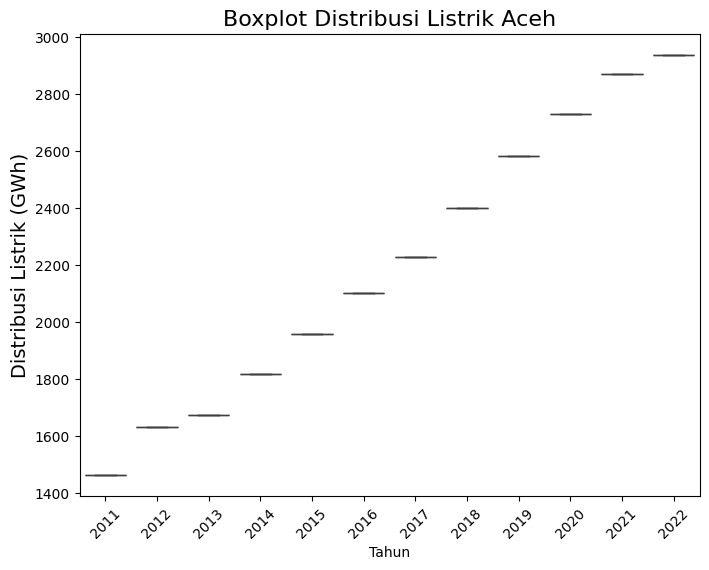

Outliers for Aceh:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


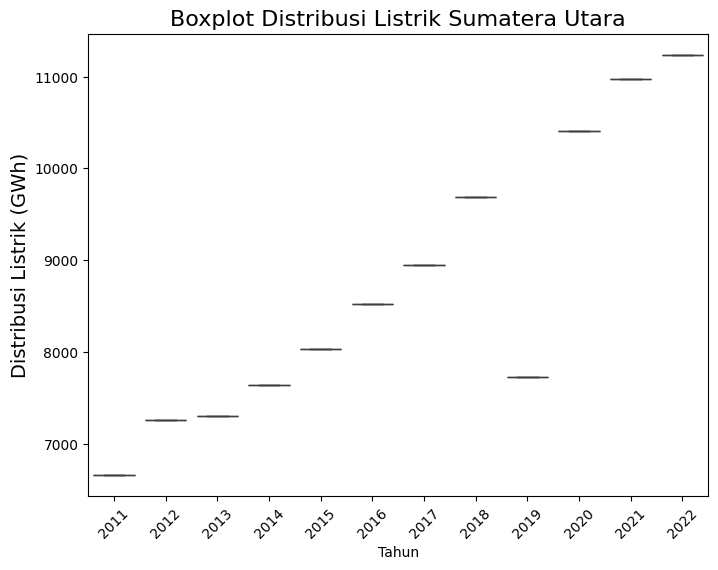

Outliers for Sumatera Utara:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


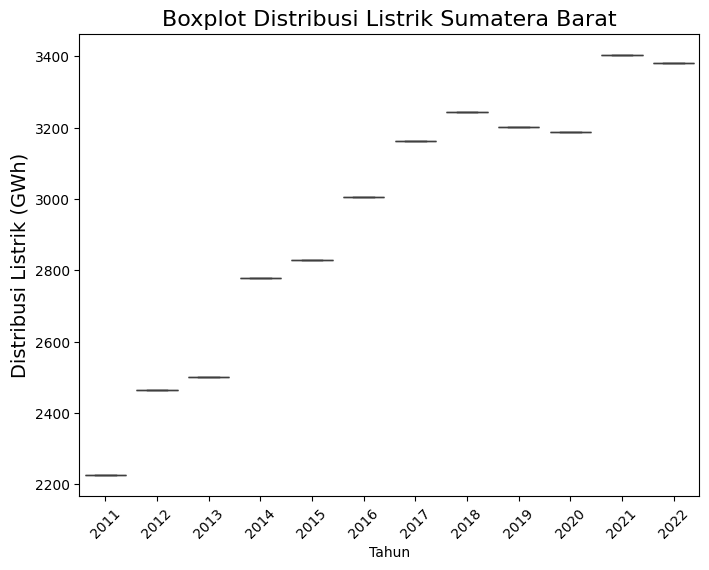

Outliers for Sumatera Barat:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


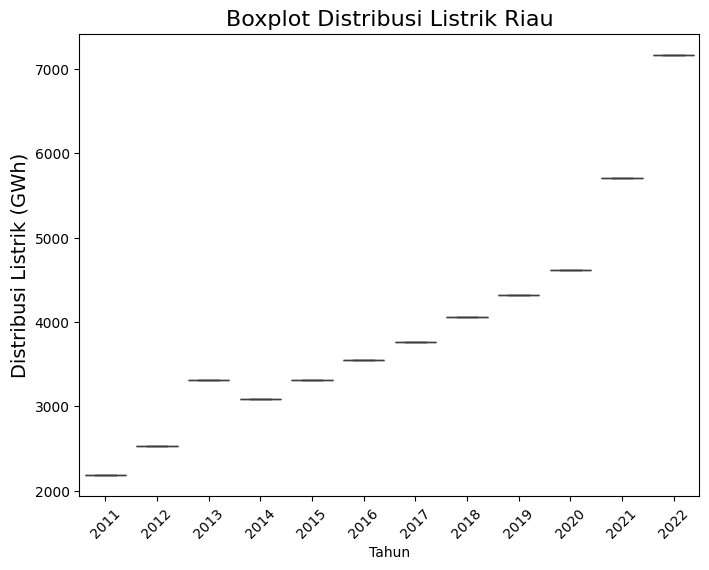

Outliers for Riau:
    Provinsi  Tahun  Distribusi_Listrik
377     Riau   2022         7166.300988


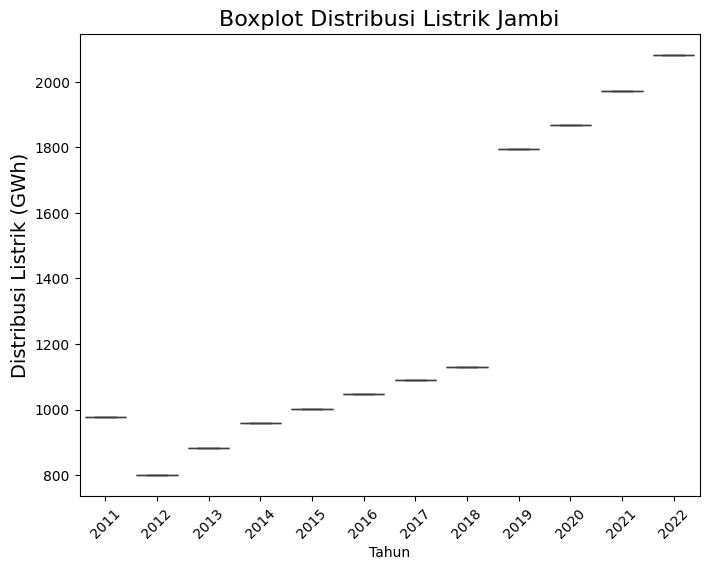

Outliers for Jambi:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


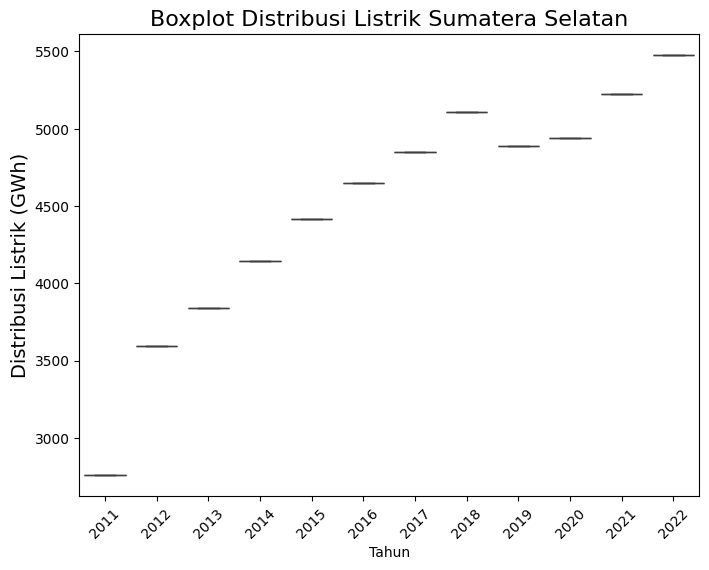

Outliers for Sumatera Selatan:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


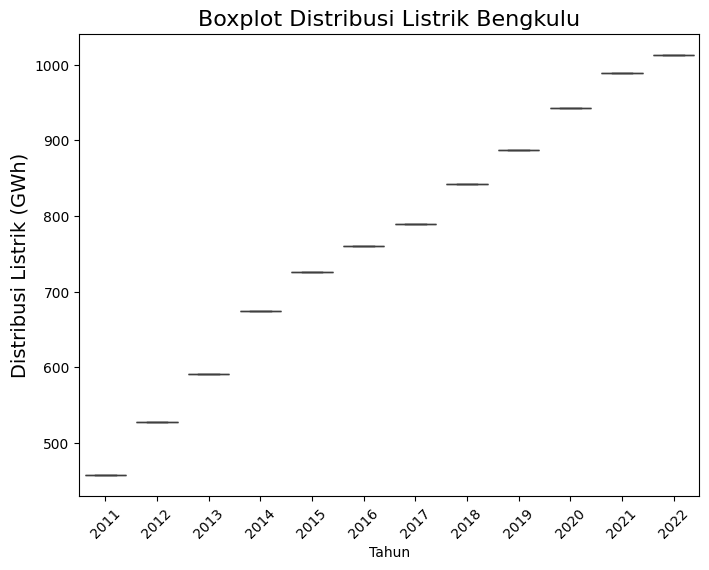

Outliers for Bengkulu:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


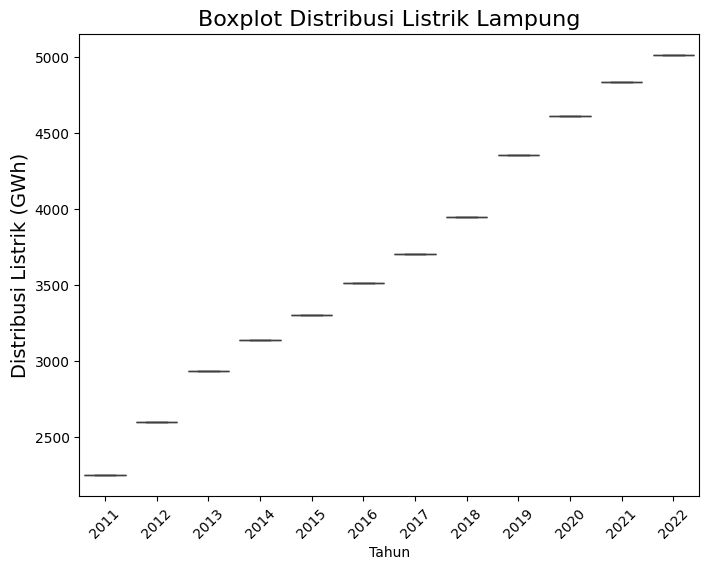

Outliers for Lampung:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


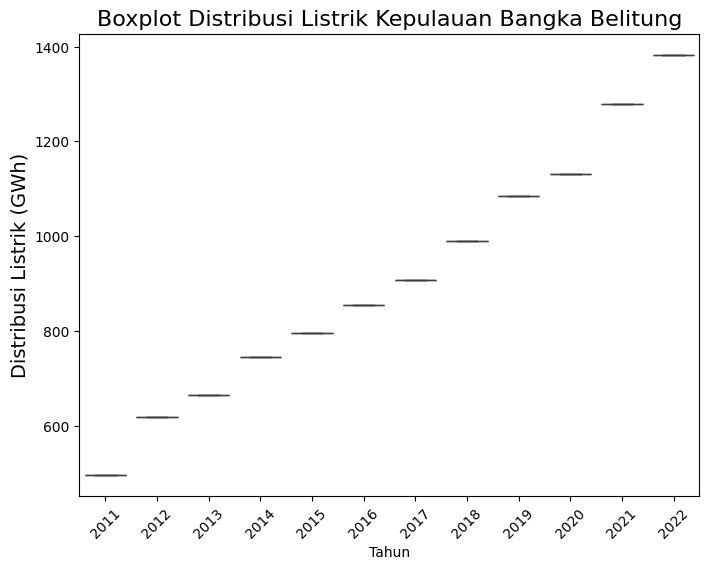

Outliers for Kepulauan Bangka Belitung:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


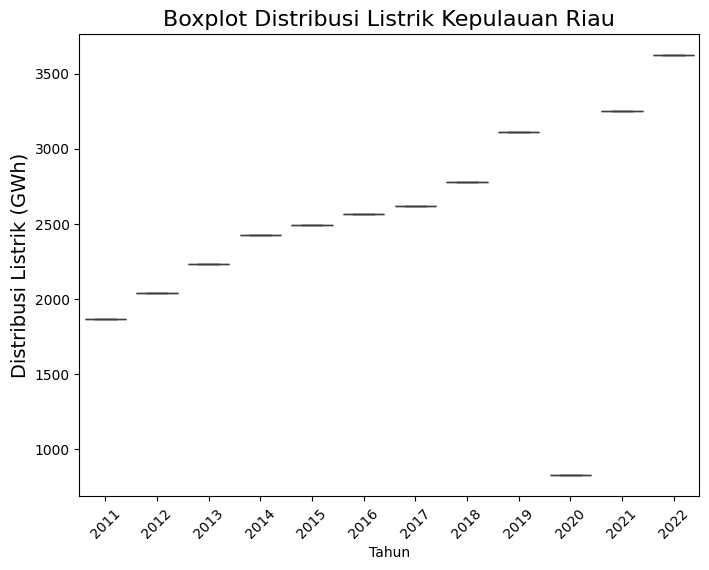

Outliers for Kepulauan Riau:
           Provinsi  Tahun  Distribusi_Listrik
315  Kepulauan Riau   2020           825.11296


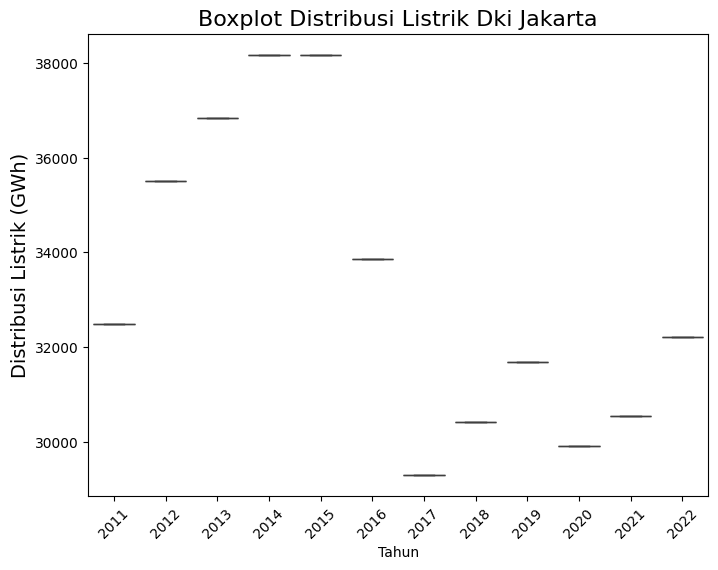

Outliers for Dki Jakarta:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


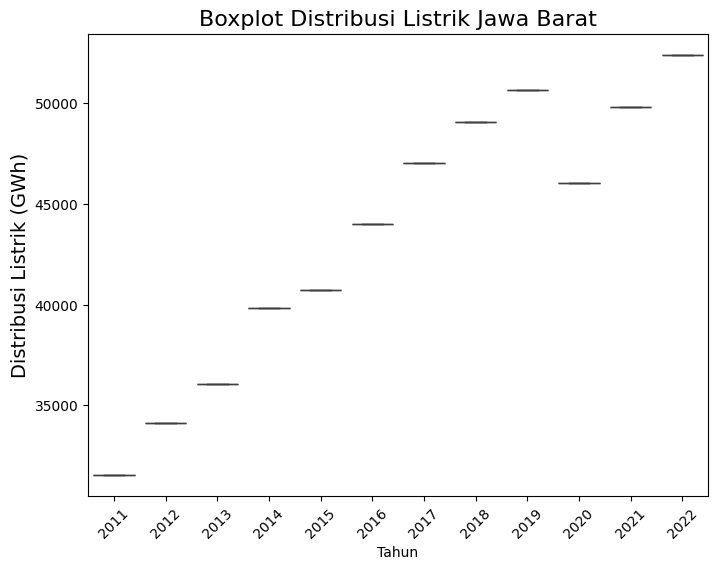

Outliers for Jawa Barat:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


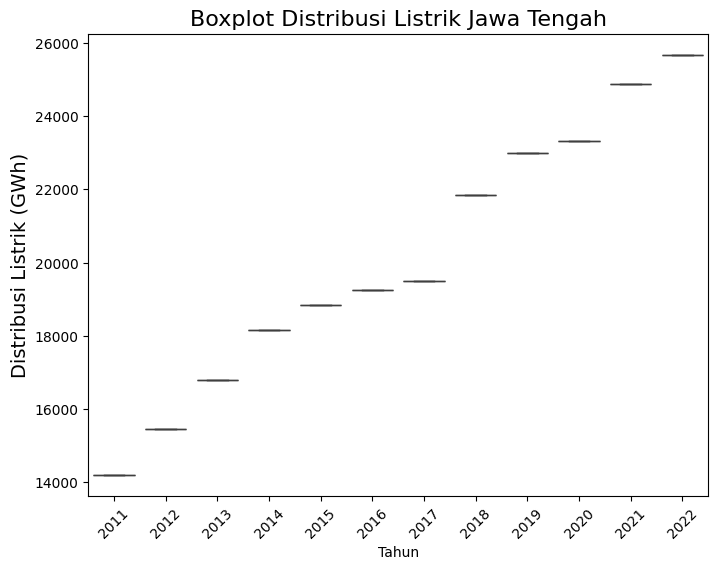

Outliers for Jawa Tengah:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


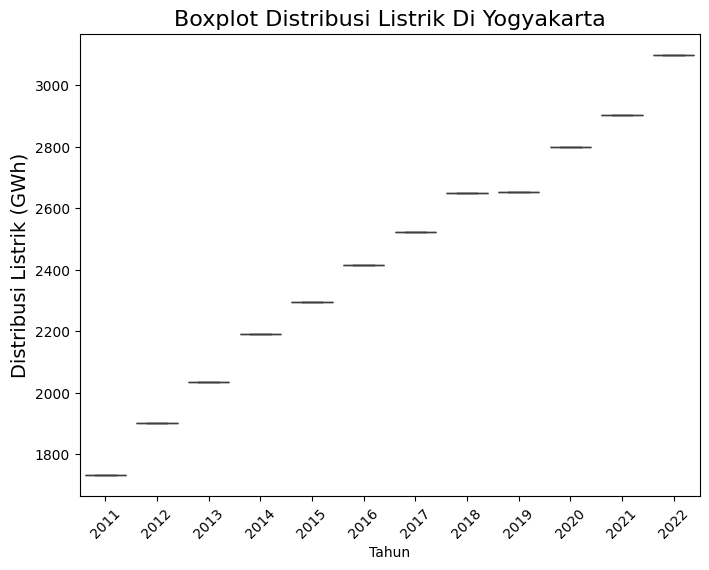

Outliers for Di Yogyakarta:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


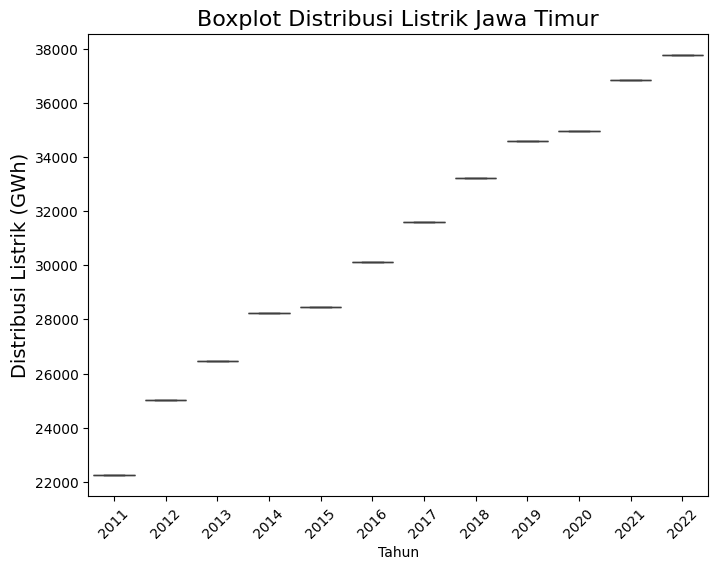

Outliers for Jawa Timur:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


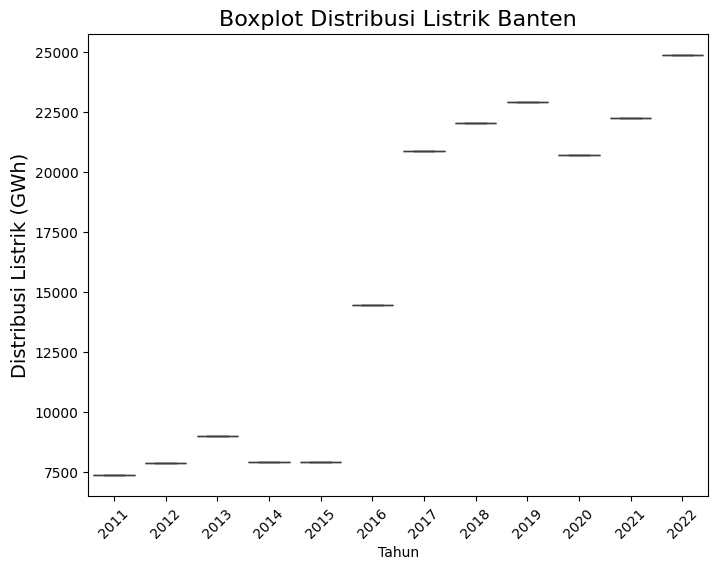

Outliers for Banten:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


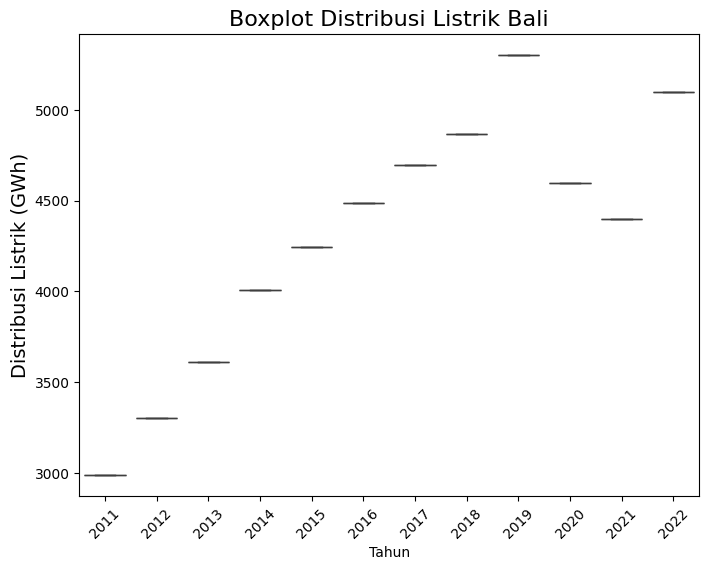

Outliers for Bali:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


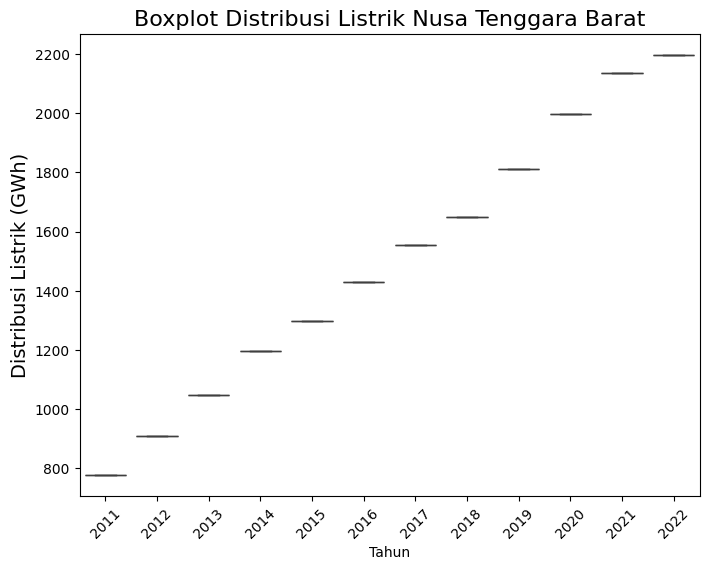

Outliers for Nusa Tenggara Barat:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


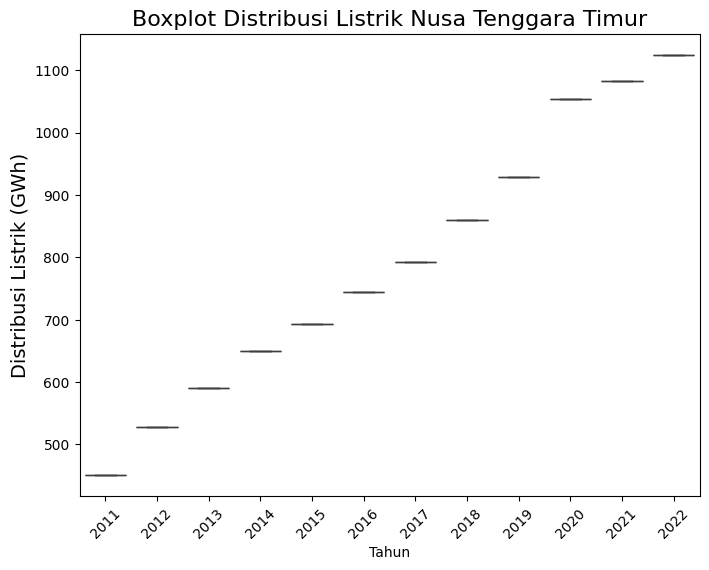

Outliers for Nusa Tenggara Timur:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


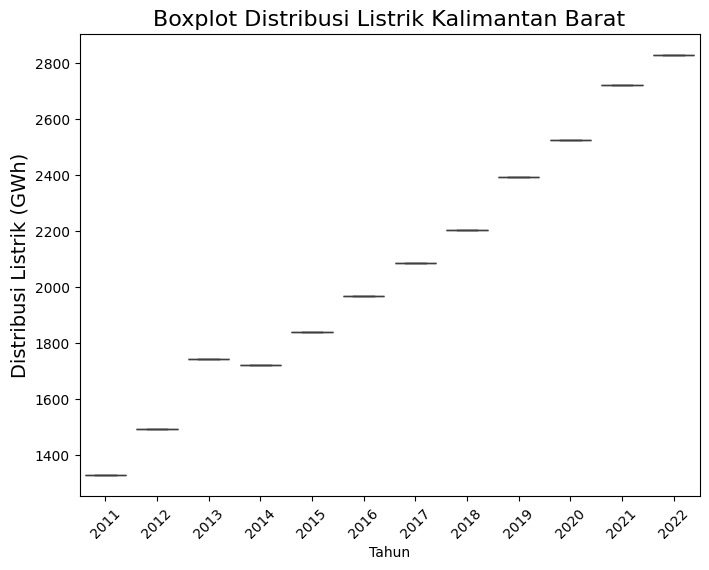

Outliers for Kalimantan Barat:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


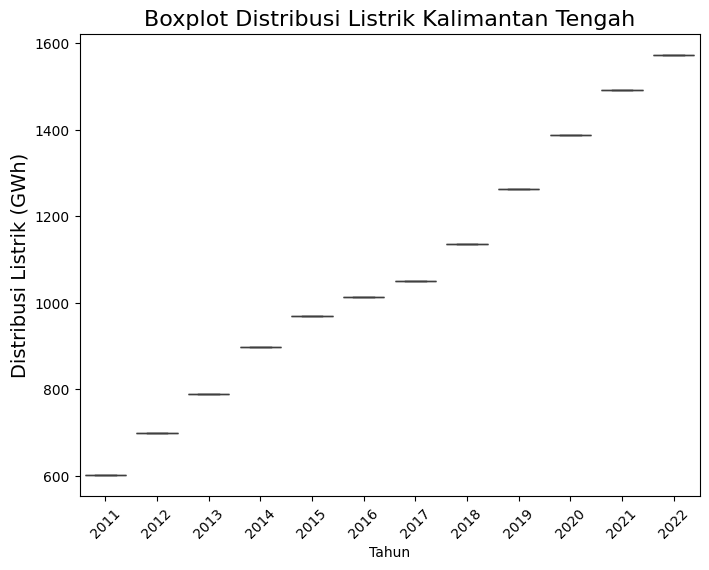

Outliers for Kalimantan Tengah:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


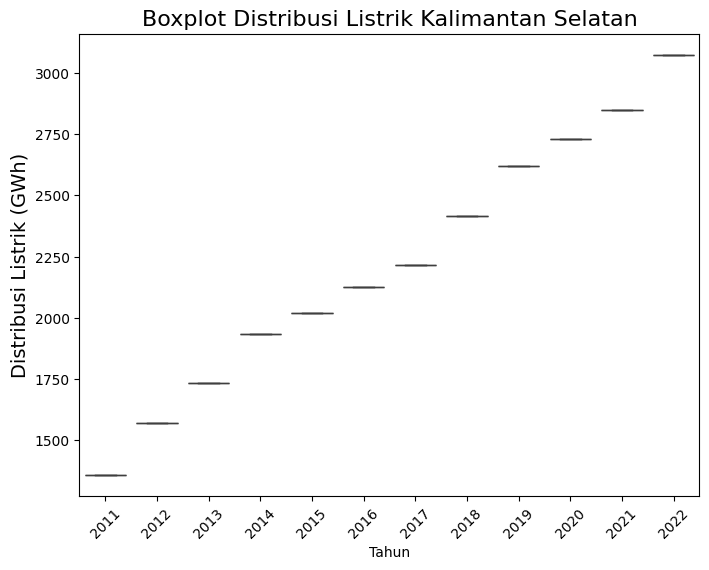

Outliers for Kalimantan Selatan:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


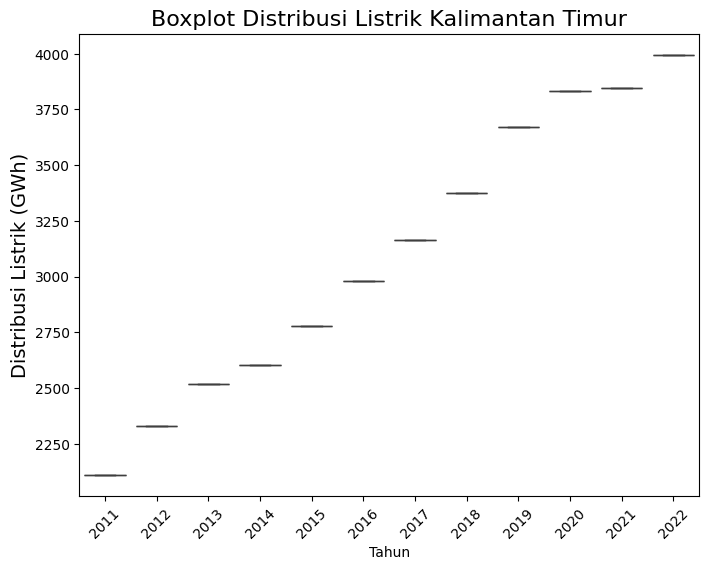

Outliers for Kalimantan Timur:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


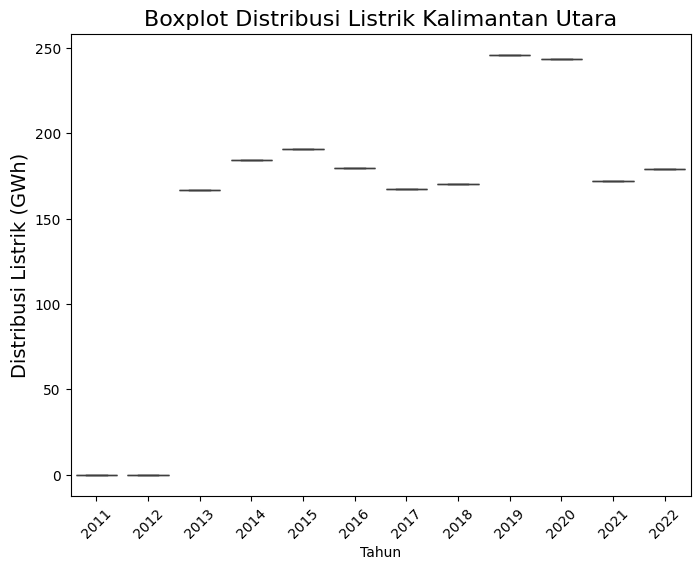

Outliers for Kalimantan Utara:
             Provinsi  Tahun  Distribusi_Listrik
23   Kalimantan Utara   2011            0.000000
57   Kalimantan Utara   2012            0.000000
295  Kalimantan Utara   2019          245.819860
329  Kalimantan Utara   2020          243.387872


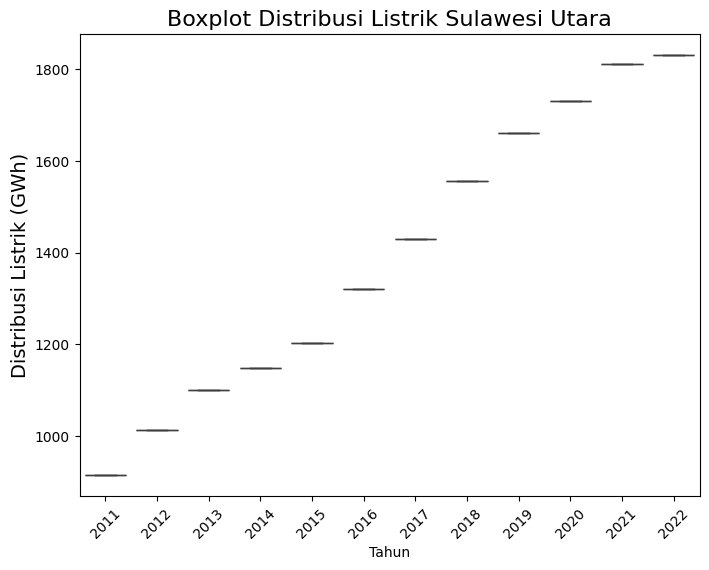

Outliers for Sulawesi Utara:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


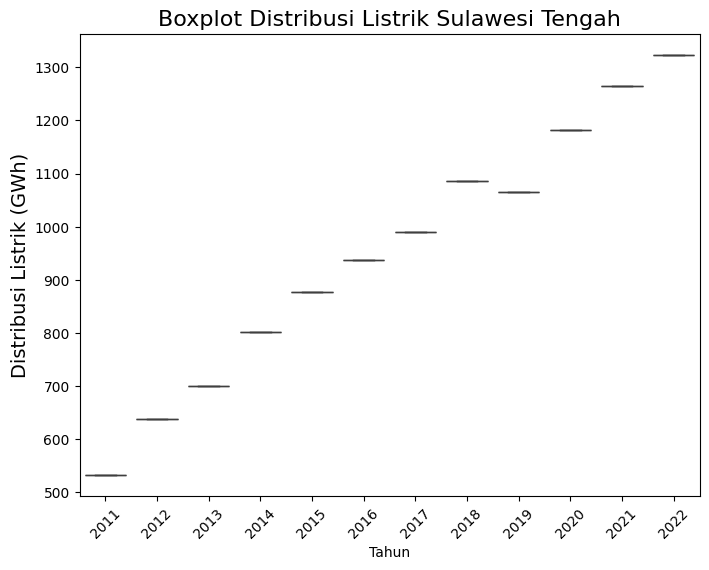

Outliers for Sulawesi Tengah:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


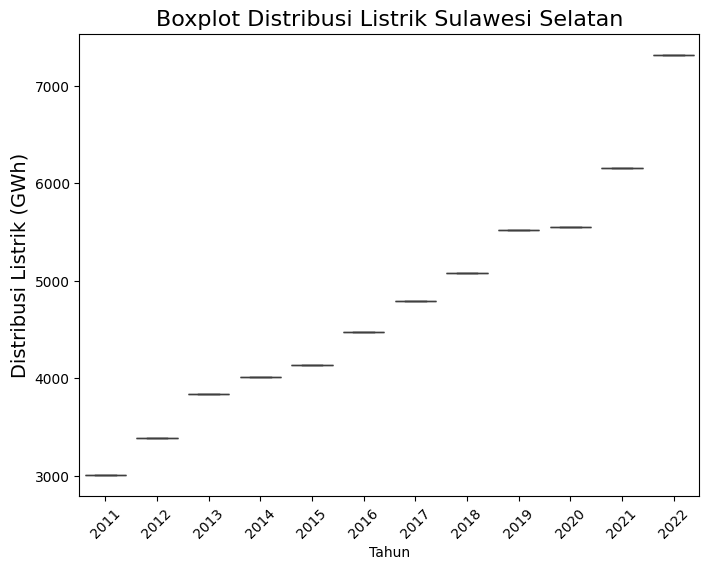

Outliers for Sulawesi Selatan:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


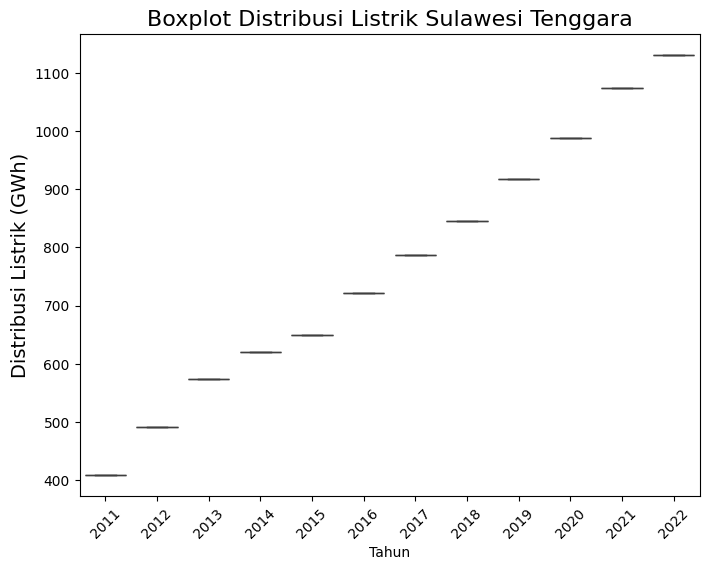

Outliers for Sulawesi Tenggara:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


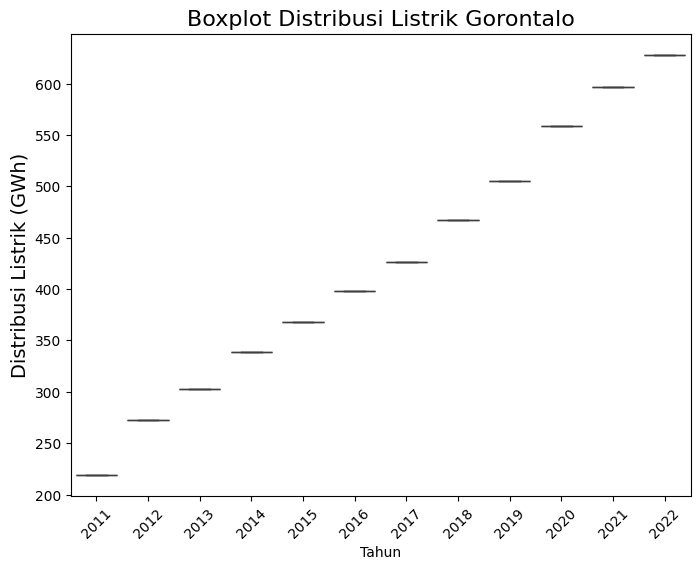

Outliers for Gorontalo:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


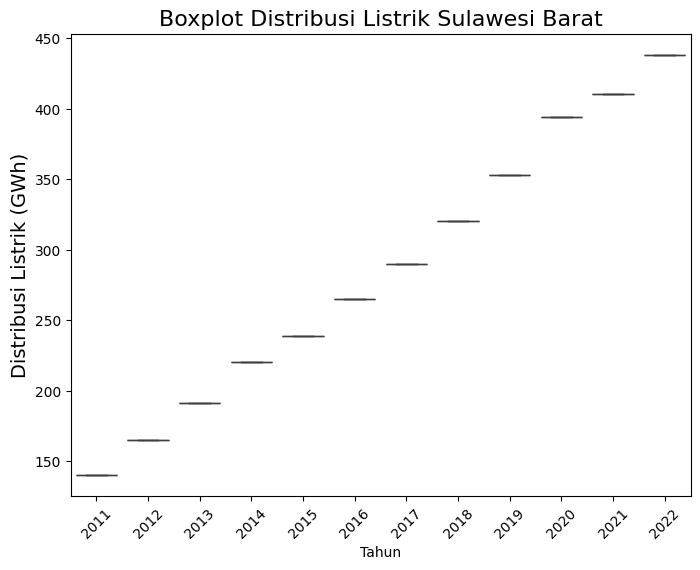

Outliers for Sulawesi Barat:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


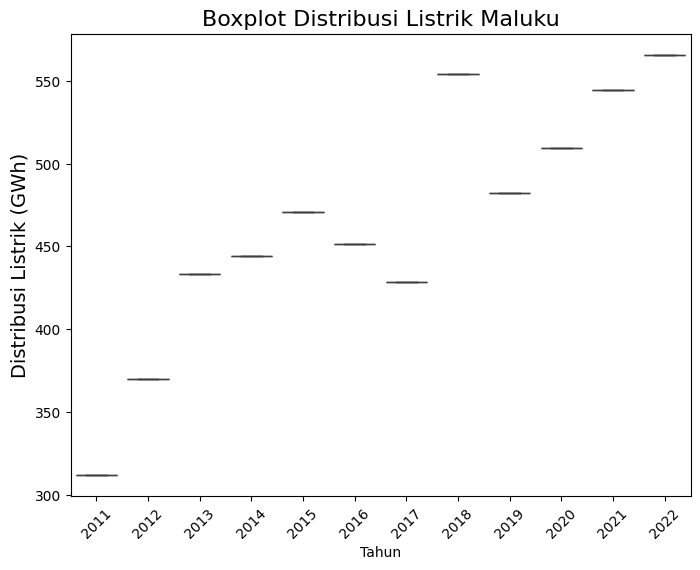

Outliers for Maluku:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


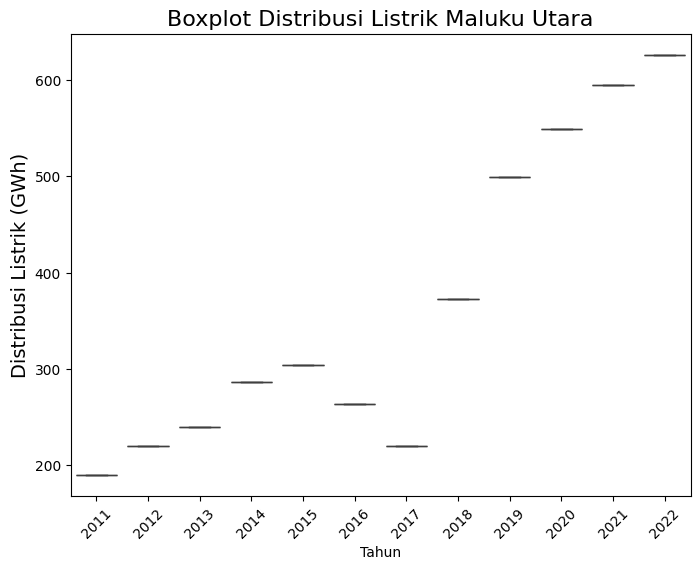

Outliers for Maluku Utara:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


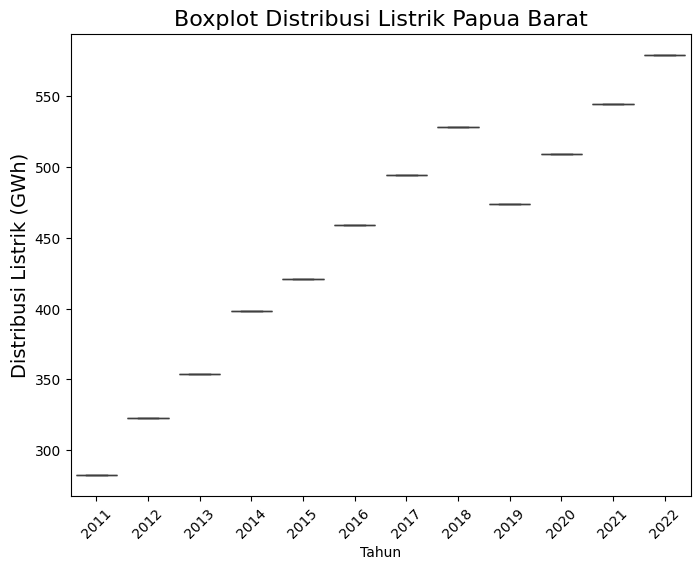

Outliers for Papua Barat:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


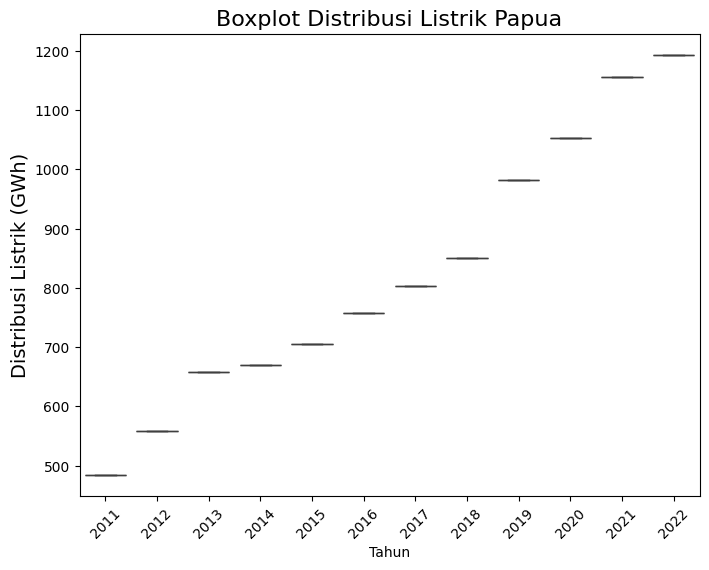

Outliers for Papua:
Empty DataFrame
Columns: [Provinsi, Tahun, Distribusi_Listrik]
Index: []


In [ ]:
df_long = data.melt(id_vars='Provinsi', var_name='Tahun', value_name='Distribusi_Listrik')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'])

for provinsi in df_long['Provinsi'].unique():
    df_provinsi = df_long[df_long['Provinsi'] == provinsi]

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Tahun', y='Distribusi_Listrik', data=df_provinsi)
    plt.title(f'Boxplot Distribusi Listrik {provinsi}', fontsize=16)
    plt.ylabel('Distribusi Listrik (GWh)', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

    Q1 = df_provinsi['Distribusi_Listrik'].quantile(0.25)
    Q3 = df_provinsi['Distribusi_Listrik'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_provinsi[(df_provinsi['Distribusi_Listrik'] < (Q1 - 1.5 * IQR)) |
                           (df_provinsi['Distribusi_Listrik'] > (Q3 + 1.5 * IQR))]

    print(f"Outliers for {provinsi}:")
    print(outliers)


Outliers for Kalimantan Utara:
*   Kalimantan Utara  (2011)                0.00 GWh
*   Kalimantan Utara   (2012)                0.00 GWh
*  Kalimantan Utara   (2012)                0.00 GWh
*   Kalimantan Utara   (2019)              264.55 GWh
*   Kalimantan Utara   (2020)              261.82 GWh

Outliers for Kepulauan Riau:
*   Kepulauan Riau   (2020)               887.6 GWh

Outliers for Riau:

*   Riau   (2022)             7691.64 GWh

### Tren Data

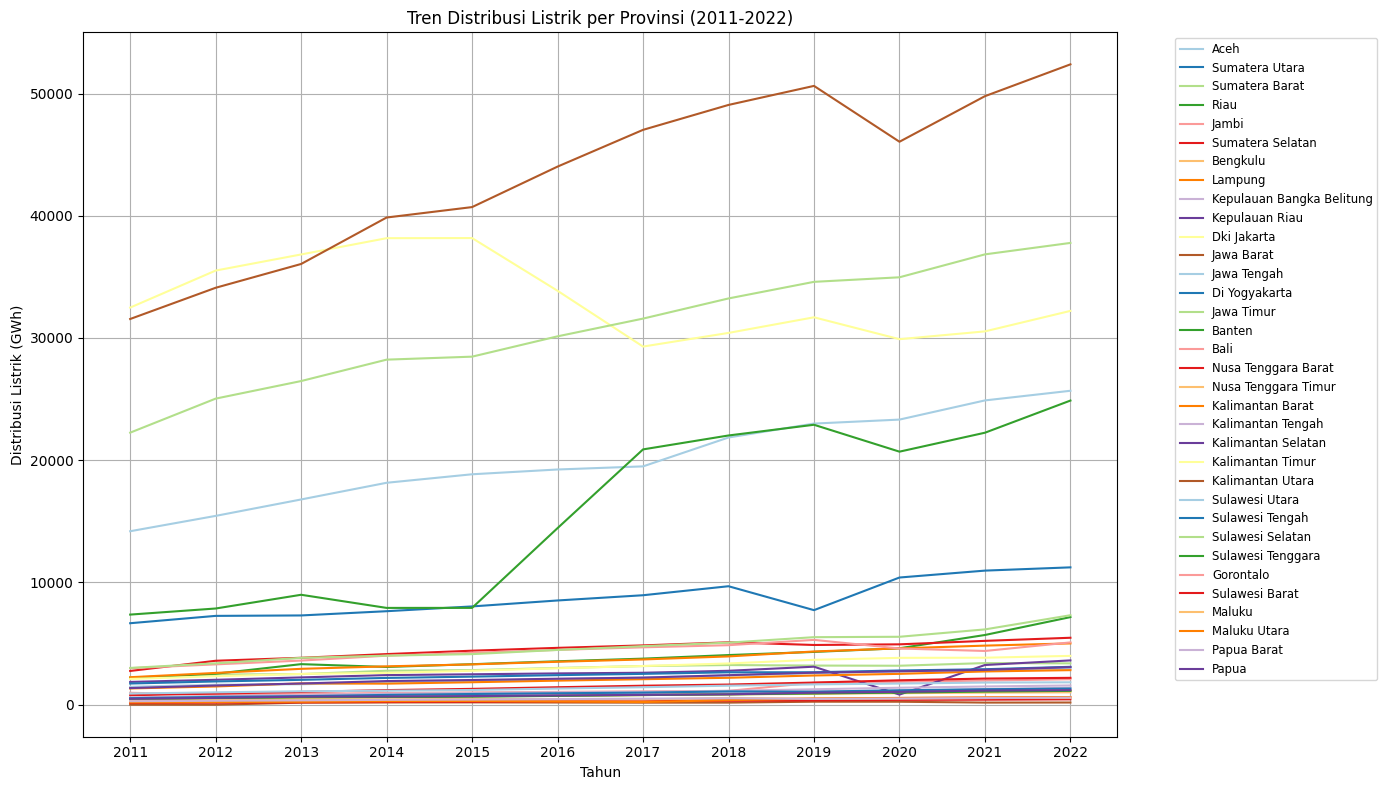

In [ ]:
palette = sns.color_palette("Paired", data.shape[0])

plt.figure(figsize=(14, 8))

for i in range(data.shape[0]):
    plt.plot(data.columns[1:], data.iloc[i, 1:],
             label=data.iloc[i, 0], color=palette[i])

plt.title("Tren Distribusi Listrik per Provinsi (2011-2022)")
plt.xlabel("Tahun")
plt.ylabel("Distribusi Listrik (GWh)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

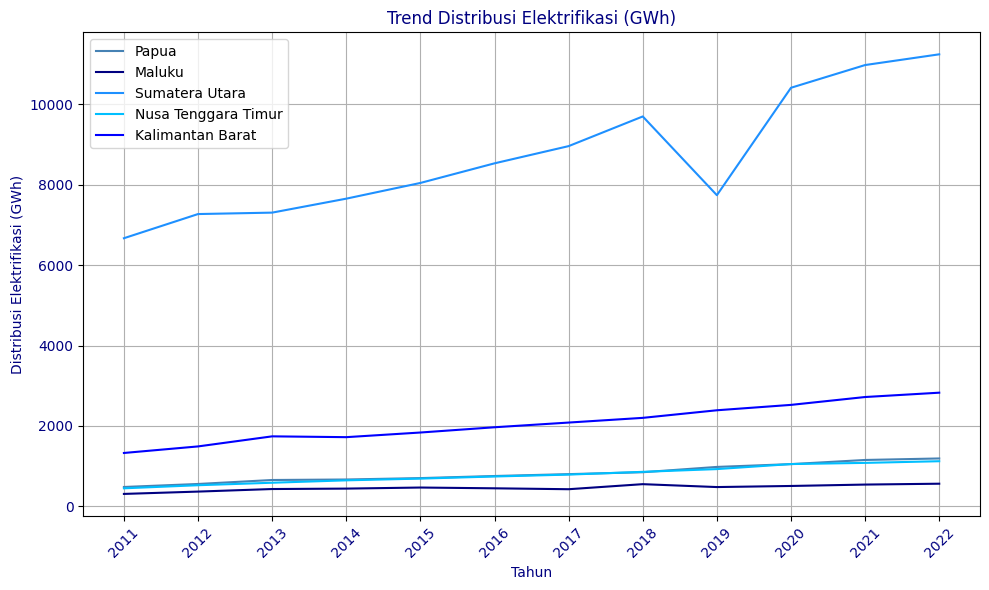

In [ ]:
provinces_of_interest = ['Papua', 'Maluku', 'Sumatera Utara', 'Nusa Tenggara Timur', 'Kalimantan Barat']
filtered_data = data[data['Provinsi'].isin(provinces_of_interest)]
filtered_data_transposed = filtered_data.set_index('Provinsi').transpose()


plt.figure(figsize=(10,6))
colors = ['steelblue', 'navy','dodgerblue', 'deepskyblue','blue']

for i, province in enumerate(provinces_of_interest):
    plt.plot(filtered_data_transposed.index, filtered_data_transposed[province], label=province, color=colors[i])

plt.title("Trend Distribusi Elektrifikasi (GWh)", color='navy')
plt.xlabel("Tahun", color='navy')
plt.ylabel("Distribusi Elektrifikasi (GWh)", color='navy')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, color='navy')
plt.yticks(color='navy')
plt.tight_layout()

plt.show()

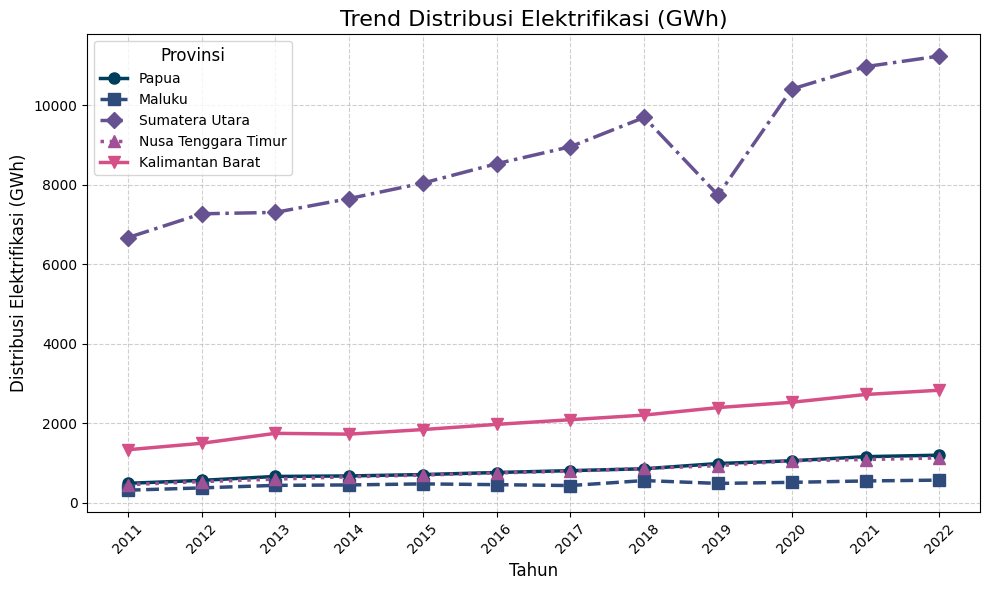

In [ ]:
provinces_of_interest = ['Papua', 'Maluku', 'Sumatera Utara', 'Nusa Tenggara Timur', 'Kalimantan Barat']

filtered_data = data[data['Provinsi'].isin(provinces_of_interest)]

filtered_data_transposed = filtered_data.set_index('Provinsi').transpose()

plt.figure(figsize=(10, 6))

colors = ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087']
markers = ['o', 's', 'D', '^', 'v']
line_styles = ['-', '--', '-.', ':', '-']

# Plot each province with the corresponding color, marker, and line style
for i, province in enumerate(provinces_of_interest):
    plt.plot(filtered_data_transposed.index, filtered_data_transposed[province],
             label=province, color=colors[i], marker=markers[i], linestyle=line_styles[i], linewidth=2.5, markersize=8)

# Customizing the plot
plt.title("Trend Distribusi Elektrifikasi (GWh)", fontsize=16, color='black')
plt.xlabel("Tahun", fontsize=12, color='black')
plt.ylabel("Distribusi Elektrifikasi (GWh)", fontsize=12, color='black')
plt.legend(title="Provinsi", fontsize=10, title_fontsize='12')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')
plt.tight_layout()

# Show the plot
plt.show()

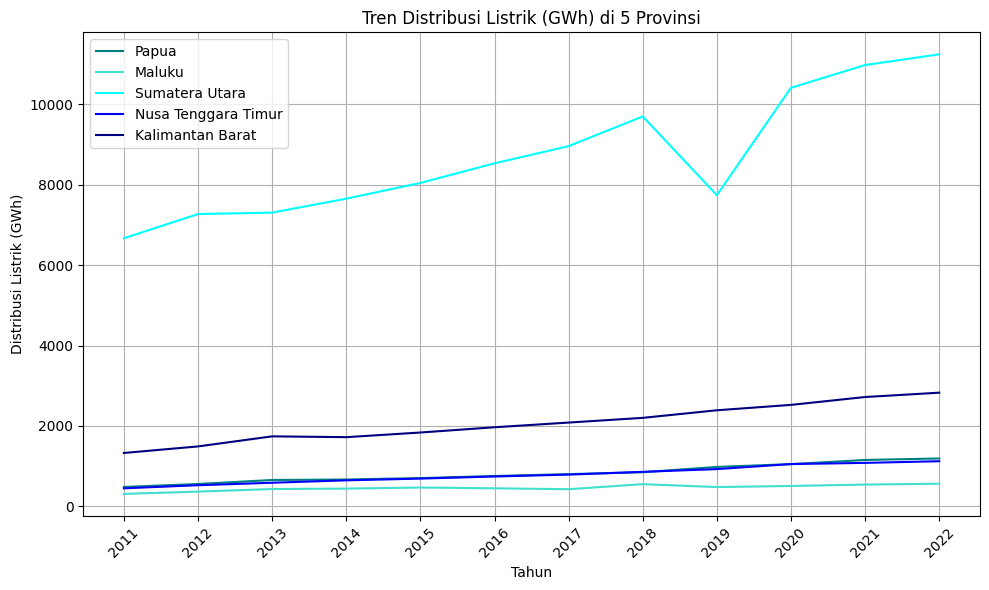

In [ ]:
import matplotlib.pyplot as plt

# Define color palette for the plot
colors = ['teal', 'turquoise', 'aqua', 'blue', 'navy']

# Plotting the trend for the selected provinces with specified colors
plt.figure(figsize=(10,6))

for i, province in enumerate(provinces_of_interest):
    plt.plot(filtered_data_transposed.index, filtered_data_transposed[province], label=province, color=colors[i])

plt.title("Tren Distribusi Listrik (GWh) di 5 Provinsi")
plt.xlabel("Tahun")
plt.ylabel("Distribusi Listrik (GWh)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


# Prophet

## Nusa Tenggara Timur

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/b8kgqk3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/klt9iuls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46139', 'data', 'file=/tmp/tmp12ct70lf/b8kgqk3c.json', 'init=/tmp/tmp12ct70lf/klt9iuls.json', 'output', 'file=/tmp/tmp12ct70lf/prophet_model_k0zy63r/prophet_model-20241019002137.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

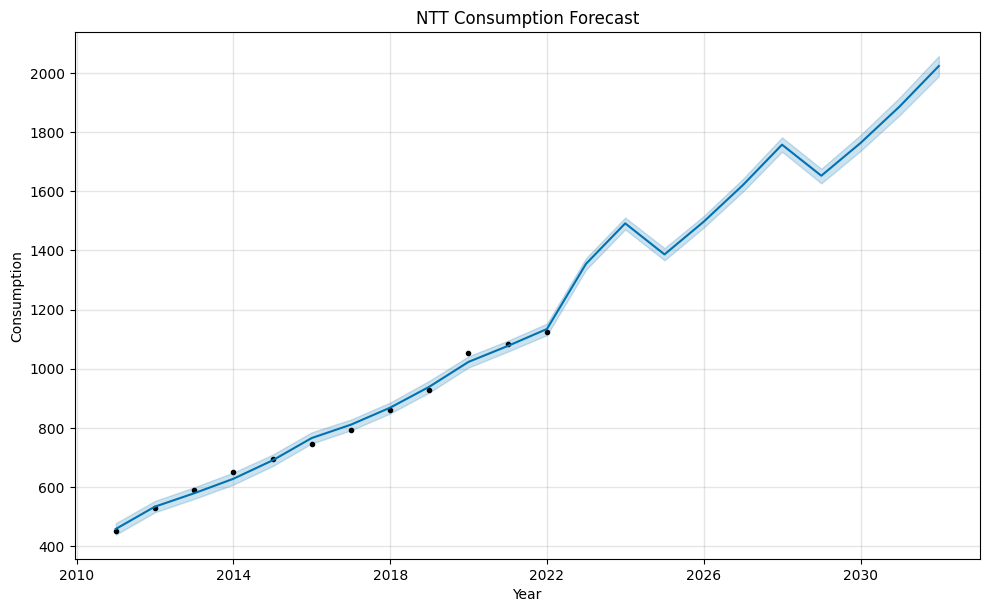

Error Metrics:
         Metric       Value
0           MAE   12.584074
1           MSE  225.146630
2          RMSE   15.004887
3  Accuracy (%)   98.377664


In [ ]:
# Filter the data for Nusa Tenggara Timur (NTT)
ntt_data = data[data['Provinsi'] == 'Nusa Tenggara Timur'].iloc[0, 1:]

# Transform the data into Prophet format with columns 'ds' and 'y'
ntt_df = pd.DataFrame({
    'ds': pd.to_datetime(ntt_data.index, format='%Y'),
    'y': ntt_data.values
})

# Initialize and fit the model
model = Prophet()
model.fit(ntt_df)

# Create future dataframe for forecasting next 5 years
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = ntt_df['y'].values
predicted = forecast['yhat'][:len(ntt_df)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(forecast)
plt.title("NTT Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.show()

# Display forecasted results
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

In [ ]:
ntt_data = data[data['Provinsi'] == 'Nusa Tenggara Timur'].iloc[0, 1:]
ntt_data

2011     451.170806
2012      527.89126
2013     589.875411
2014     649.450048
2015     692.553312
2016     744.804891
2017     791.875975
2018     860.543739
2019     928.726108
2020    1053.683008
2021    1083.241392
2022    1124.478047
Name: 18, dtype: object

In [ ]:
forecast_results

ds         yhat   yhat_lower   yhat_upper
0  2011-01-01   456.960746   437.424559   476.296510
1  2012-01-01   532.595911   513.543612   551.889498
2  2013-01-01   577.920940   558.889397   597.845209
3  2014-01-01   626.912127   607.098852   648.099635
4  2015-01-01   689.226248   669.802756   708.359675
5  2016-01-01   764.861413   746.445681   784.232381
6  2017-01-01   810.252730   790.813315   827.663254
7  2018-01-01   867.729039   848.080071   885.035965
8  2019-01-01   938.558835   918.893107   958.677132
9  2020-01-01  1022.713824  1003.578869  1041.605183
10 2021-01-01  1076.582020  1057.456300  1094.309919
11 2022-01-01  1134.093032  1113.289239  1152.264566
12 2022-12-31  1354.734884  1334.802668  1373.946355
13 2023-12-31  1491.687258  1471.156010  1511.141525
14 2024-12-31  1386.532673  1366.642632  1407.748503
15 2025-12-31  1497.230372  1477.265369  1516.515412
16 2026-12-31  1621.103027  1598.963598  1642.047987
17 2027-12-31  1758.055402  1734.318379  1782.608077
18 2028-12-31  1652.900817  1627.070348  1676.505879
19 2029-12-31  1763.598516  1736.846232  1790.698673
20 2030-12-31  1887.471171  1857.806581  1917.873589
21 2031-12-31  2024.423546  1989.949873  2058.407350

## Sumatera Utara

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/85e9oukq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/dxfsw0xt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95592', 'data', 'file=/tmp/tmp12ct70lf/85e9oukq.json', 'init=/tmp/tmp12ct70lf/dxfsw0xt.json', 'output', 'file=/tmp/tmp12ct70lf/prophet_model6h3z66ub/prophet_model-20241019002137.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

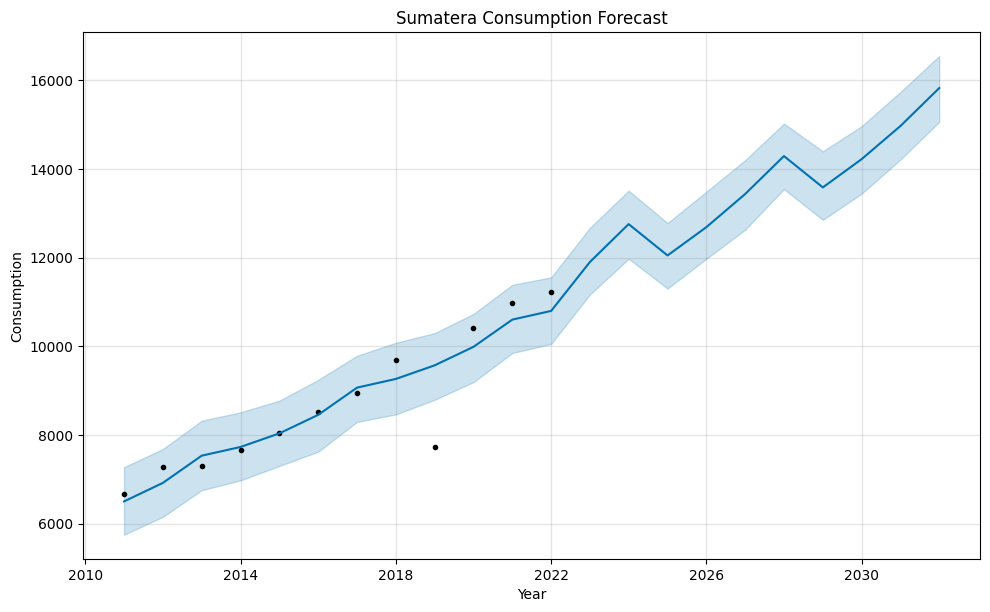

Error Metrics:
         Metric          Value
0           MAE     375.423749
1           MSE  356439.956355
2          RMSE     597.025926
3  Accuracy (%)      95.574675


In [ ]:
# Filter the data for Sumatera Utara
sumatera_data = data[data['Provinsi'] == 'Sumatera Utara'].iloc[0, 1:]

# Transform the data into Prophet format with columns 'ds' and 'y'
sumatera_df = pd.DataFrame({
    'ds': pd.to_datetime(sumatera_data.index, format='%Y'),
    'y': sumatera_data.values
})

# Initialize and fit the model
model = Prophet()
model.fit(sumatera_df)

# Create future dataframe for forecasting next 5 years
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = sumatera_df['y'].values
predicted = forecast['yhat'][:len(sumatera_df)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(forecast)
plt.title("Sumatera Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.show()

# Display forecasted results
forecast_results_sumatera = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics_sumatera = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics_sumatera)



In [ ]:
forecast_results_sumatera

ds          yhat    yhat_lower    yhat_upper
0  2011-01-01   6498.679501   5745.511105   7270.852282
1  2012-01-01   6915.953948   6149.976747   7681.848340
2  2013-01-01   7531.106893   6751.639415   8320.970478
3  2014-01-01   7727.357975   6973.767594   8509.814480
4  2015-01-01   8034.059678   7298.479050   8772.827155
5  2016-01-01   8451.334124   7620.118422   9241.165388
6  2017-01-01   9066.487070   8292.552299   9786.550913
7  2018-01-01   9262.738157   8462.135207  10078.933464
8  2019-01-01   9569.439862   8792.278924  10297.765829
9  2020-01-01   9986.714312   9190.988298  10730.229392
10 2021-01-01  10601.867262   9846.971416  11387.875299
11 2022-01-01  10798.118350  10053.845901  11554.905021
12 2022-12-31  11900.263648  11166.327748  12672.126423
13 2023-12-31  12757.143825  11976.123727  13512.108502
14 2024-12-31  12049.868302  11302.181794  12782.188918
15 2025-12-31  12687.872652  11973.555352  13487.389730
16 2026-12-31  13435.643843  12629.024844  14200.499204
17 2027-12-31  14292.524020  13546.436064  15026.574583
18 2028-12-31  13585.248497  12852.953187  14400.843209
19 2029-12-31  14223.252847  13443.897190  14968.235096
20 2030-12-31  14971.024038  14215.388322  15740.541551
21 2031-12-31  15827.904215  15063.886100  16552.498246

## Papua

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/7mtd6kym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/a7rsnv1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10633', 'data', 'file=/tmp/tmp12ct70lf/7mtd6kym.json', 'init=/tmp/tmp12ct70lf/a7rsnv1g.json', 'output', 'file=/tmp/tmp12ct70lf/prophet_model87_xk2je/prophet_model-20241019002138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

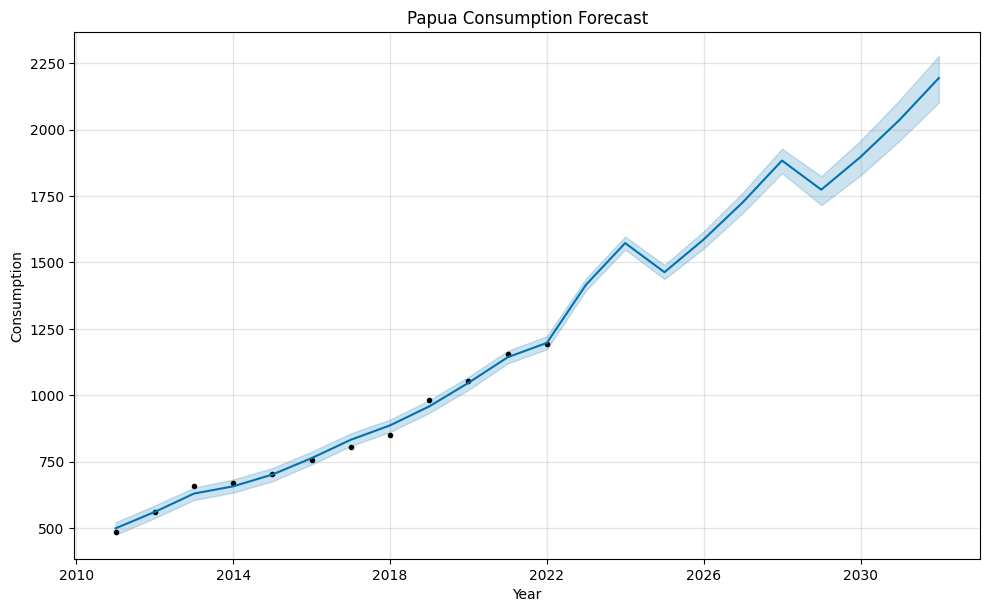

Error Metrics:
         Metric       Value
0           MAE   14.911454
1           MSE  345.473336
2          RMSE   18.586913
3  Accuracy (%)   98.075747


In [ ]:
# Filter the data for Sumatera Utara
papua_data = data[data['Provinsi'] == 'Papua'].iloc[0, 1:]

# Transform the data into Prophet format with columns 'ds' and 'y'
papua_df = pd.DataFrame({
    'ds': pd.to_datetime(papua_data.index, format='%Y'),
    'y': papua_data.values
})

# Initialize and fit the model
model = Prophet()
model.fit(papua_df)

# Create future dataframe for forecasting next 5 years
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = papua_df['y'].values
predicted = forecast['yhat'][:len(papua_df)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(forecast)
plt.title("Papua Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.show()

# Display forecasted results
forecast_results_papua = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics_papua = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics_papua)



In [ ]:
forecast_results_papua

ds         yhat   yhat_lower   yhat_upper
0  2011-01-01   498.588435   474.294310   521.232643
1  2012-01-01   560.292402   537.234964   584.772176
2  2013-01-01   629.567507   605.207636   651.849989
3  2014-01-01   656.760065   633.123715   682.537917
4  2015-01-01   701.207337   675.770763   725.605250
5  2016-01-01   762.911296   738.684455   787.276140
6  2017-01-01   832.201267   808.610016   856.364409
7  2018-01-01   886.349302   861.304610   908.325290
8  2019-01-01   957.809522   932.986442   981.182343
9  2020-01-01  1046.526427  1019.784445  1068.975429
10 2021-01-01  1142.888499  1119.535055  1167.253945
11 2022-01-01  1197.094018  1172.921165  1221.968762
12 2022-12-31  1415.782670  1394.237124  1439.552812
13 2023-12-31  1572.940850  1548.305795  1597.585348
14 2024-12-31  1463.216397  1437.176984  1490.397388
15 2025-12-31  1586.331401  1552.361280  1617.071330
16 2026-12-31  1726.527384  1686.462381  1763.030350
17 2027-12-31  1883.685564  1836.255185  1928.083868
18 2028-12-31  1773.961111  1715.679653  1824.718393
19 2029-12-31  1897.076115  1827.159521  1958.853019
20 2030-12-31  2037.272098  1958.719266  2111.646277
21 2031-12-31  2194.430278  2102.224229  2277.635035

## Kalimantan Barat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/f2yxe3hi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/zb5xn_d4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59225', 'data', 'file=/tmp/tmp12ct70lf/f2yxe3hi.json', 'init=/tmp/tmp12ct70lf/zb5xn_d4.json', 'output', 'file=/tmp/tmp12ct70lf/prophet_modeldl2g82qm/prophet_model-20241019002138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

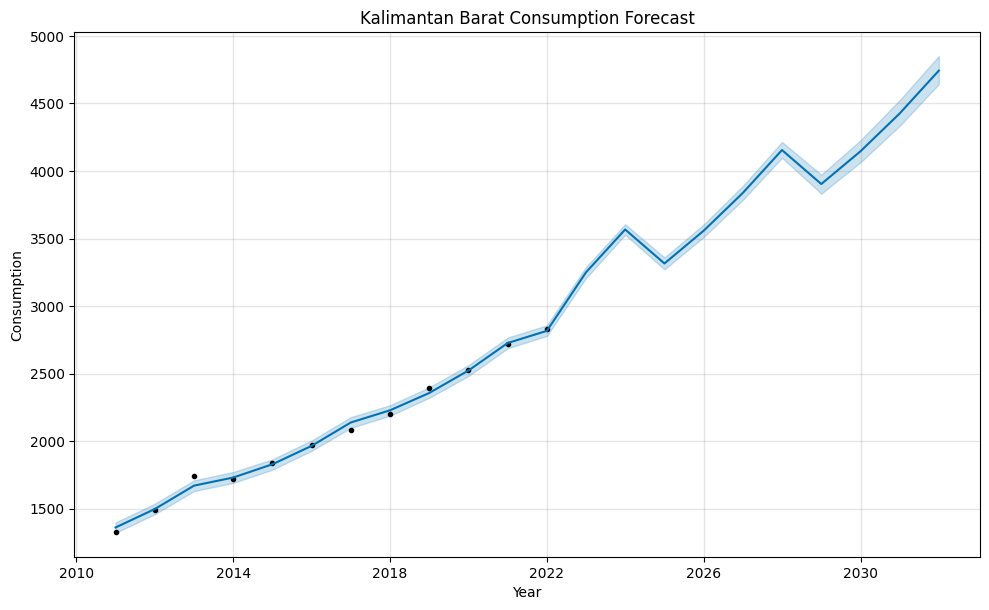

Error Metrics:
         Metric       Value
0           MAE   21.798431
1           MSE  932.429938
2          RMSE   30.535716
3  Accuracy (%)   98.847983


In [ ]:
# Filter the data for Sumatera Utara
kalbar_data = data[data['Provinsi'] == 'Kalimantan Barat'].iloc[0, 1:]

# Transform the data into Prophet format with columns 'ds' and 'y'
kalbar_df = pd.DataFrame({
    'ds': pd.to_datetime(kalbar_data.index, format='%Y'),
    'y': kalbar_data.values
})

# Initialize and fit the model
model = Prophet()
model.fit(kalbar_df)

# Create future dataframe for forecasting next 5 years
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = kalbar_df['y'].values
predicted = forecast['yhat'][:len(kalbar_df)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(forecast)
plt.title("Kalimantan Barat Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.show()

# Display forecasted results
forecast_results_kalbar = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics_kalbar = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics_kalbar)

In [ ]:
forecast_results_kalbar

ds         yhat   yhat_lower   yhat_upper
0  2011-01-01  1360.821698  1320.873461  1398.530746
1  2012-01-01  1497.112453  1459.179931  1536.679234
2  2013-01-01  1670.665653  1630.262733  1710.325944
3  2014-01-01  1730.671907  1690.715609  1771.456992
4  2015-01-01  1828.761740  1788.459613  1865.424552
5  2016-01-01  1964.947985  1928.429124  2004.787999
6  2017-01-01  2138.400004  2098.201311  2178.300243
7  2018-01-01  2228.510493  2188.247575  2265.913610
8  2019-01-01  2356.705701  2320.862176  2398.409943
9  2020-01-01  2522.997323  2482.385452  2562.883313
10 2021-01-01  2726.637198  2687.511320  2766.985181
11 2022-01-01  2816.748827  2779.198732  2857.782791
12 2022-12-31  3249.574188  3206.985412  3289.300137
13 2023-12-31  3567.041287  3527.448901  3606.089003
14 2024-12-31  3315.569491  3271.914412  3360.221307
15 2025-12-31  3557.824398  3510.592848  3604.209659
16 2026-12-31  3837.812524  3785.915857  3889.762653
17 2027-12-31  4155.279622  4097.971629  4215.242741
18 2028-12-31  3903.807827  3832.351340  3973.139770
19 2029-12-31  4146.062734  4064.368717  4227.545660
20 2030-12-31  4426.050860  4334.290639  4524.924358
21 2031-12-31  4743.517958  4643.207988  4851.664235

## Maluku

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/dg2kdhd3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12ct70lf/lt03f5n8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4927', 'data', 'file=/tmp/tmp12ct70lf/dg2kdhd3.json', 'init=/tmp/tmp12ct70lf/lt03f5n8.json', 'output', 'file=/tmp/tmp12ct70lf/prophet_modelafxza4kf/prophet_model-20241019002139.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

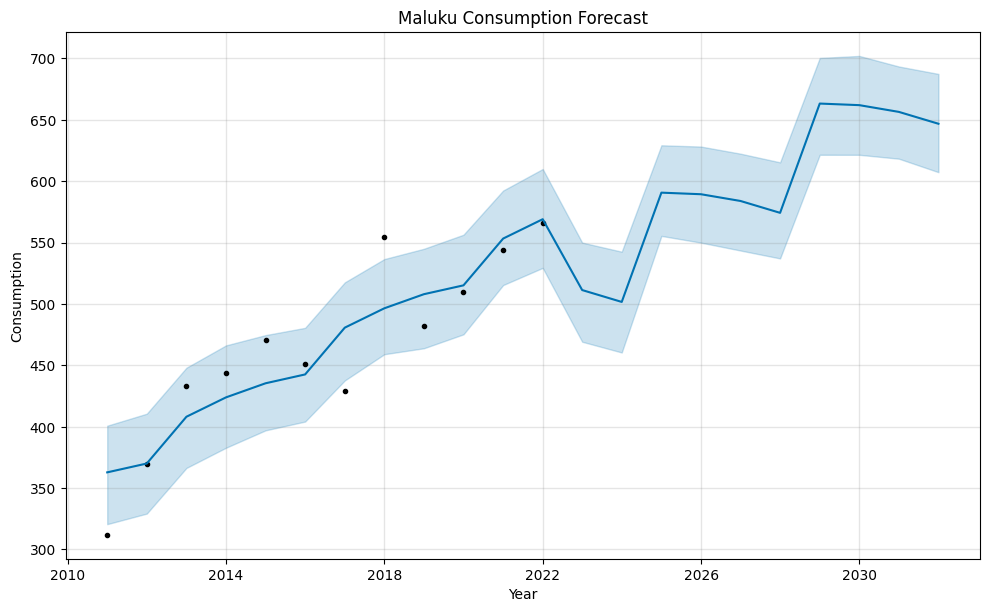

Error Metrics:
         Metric       Value
0           MAE   24.488089
1           MSE  980.873171
2          RMSE   31.318895
3  Accuracy (%)   94.386843


In [ ]:
# Filter the data for Sumatera Utara
maluku_data = data[data['Provinsi'] == 'Maluku'].iloc[0, 1:]

# Transform the data into Prophet format with columns 'ds' and 'y'
maluku_df = pd.DataFrame({
    'ds': pd.to_datetime(maluku_data.index, format='%Y'),
    'y': maluku_data.values
})

# Initialize and fit the model
model = Prophet()
model.fit(maluku_df)

# Create future dataframe for forecasting next 5 years
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = maluku_df['y'].values
predicted = forecast['yhat'][:len(maluku_df)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(forecast)
plt.title("Maluku Consumption Forecast")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.show()

# Display forecasted results
forecast_results_maluku = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics_maluku = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics_maluku)

In [ ]:
forecast_results_maluku

ds        yhat  yhat_lower  yhat_upper
0  2011-01-01  362.828443  320.626951  400.839960
1  2012-01-01  370.034603  329.226838  410.615449
2  2013-01-01  408.149232  366.423311  448.085349
3  2014-01-01  423.919694  382.878280  466.265109
4  2015-01-01  435.403340  397.050245  474.645761
5  2016-01-01  442.609500  404.215132  480.560581
6  2017-01-01  480.724129  437.695043  517.622972
7  2018-01-01  496.494591  459.081648  536.601454
8  2019-01-01  507.978237  463.918330  544.968496
9  2020-01-01  515.184397  475.270056  556.418869
10 2021-01-01  553.299025  515.412743  592.422828
11 2022-01-01  569.069487  529.396946  609.969130
12 2022-12-31  511.341144  469.226270  550.018449
13 2023-12-31  501.676928  460.480933  542.609482
14 2024-12-31  590.704634  555.452663  629.295118
15 2025-12-31  589.413133  549.983203  628.247398
16 2026-12-31  583.916040  543.534803  622.460245
17 2027-12-31  574.251824  537.110910  615.401873
18 2028-12-31  663.279530  621.549236  700.438628
19 2029-12-31  661.988030  621.532898  702.075507
20 2030-12-31  656.490937  618.358557  693.483054
21 2031-12-31  646.826720  607.375779  687.436329

# LSTM

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
data

Provinsi          2011          2012          2013  \
0                        Aceh   1463.814882   1633.083330   1674.011392   
1              Sumatera Utara   6665.988198   7266.572260   7302.070452   
2              Sumatera Barat   2226.712460   2464.968940   2502.061555   
3                        Riau   2187.841590   2534.505205   3317.918912   
4                       Jambi    976.793922    800.592895    881.405218   
5            Sumatera Selatan   2760.211676   3594.633160   3838.695607   
6                    Bengkulu    457.694070    527.546975    591.673896   
7                     Lampung   2247.876004   2599.221480   2934.952283   
8   Kepulauan Bangka Belitung    496.296226    618.521960    665.199652   
9              Kepulauan Riau   1862.743980   2037.832220   2233.736816   
10                Dki Jakarta  32487.874708  35516.021875  36834.153344   
11                 Jawa Barat  31554.065760  34107.738040  36055.068088   
12                Jawa Tengah  14191.703674  15446.690810  16790.545284   
13              Di Yogyakarta   1732.528882   1901.709375   2034.400117   
14                 Jawa Timur  22255.718154  25039.922490  26477.489853   
15                     Banten   7371.603364   7869.982900   8992.766251   
16                       Bali   2987.302804   3300.111300   3610.177336   
17        Nusa Tenggara Barat    775.721722    908.530895   1045.270259   
18        Nusa Tenggara Timur    451.170806    527.891260    589.875411   
19           Kalimantan Barat   1329.411552   1492.261460   1742.584397   
20          Kalimantan Tengah    602.243670    700.052370    788.363594   
21         Kalimantan Selatan   1359.442658   1571.093420   1734.532718   
22           Kalimantan Timur   2110.072052   2328.408760   2519.336234   
23           Kalimantan Utara      0.000000      0.000000    166.687279   
24             Sulawesi Utara    914.202092   1011.527940   1099.861196   
25            Sulawesi Tengah    532.526286    638.499795    699.749010   
26           Sulawesi Selatan   3008.132772   3386.675715   3833.530727   
27          Sulawesi Tenggara    408.704728    491.694810    573.338572   
28                  Gorontalo    219.159432    272.757465    302.883320   
29             Sulawesi Barat    140.398432    165.284715    191.460257   
30                     Maluku    311.976954    369.864445    433.444108   
31               Maluku Utara    189.647222    219.486340    238.967930   
32                Papua Barat    282.687128    322.557825    354.153977   
33                      Papua    484.426480    558.923435    657.839698   

            2014          2015          2016          2017          2018  \
0    1817.740640   1957.320300   2101.269446   2230.594949   2401.136109   
1    7649.030048   8039.579979   8526.988358   8954.823332   9691.934058   
2    2779.264448   2829.551736   3006.380409   3162.217011   3244.105422   
3    3087.287584   3312.803865   3552.943139   3768.348187   4061.613159   
4     959.433760   1001.096823   1048.697314   1088.941731   1131.119379   
5    4140.782752   4418.075574   4650.880799   4851.114165   5104.619154   
6     674.771072    725.501691    760.239194    789.644556    842.022855   
7    3137.328512   3298.532700   3512.533665   3702.025970   3950.209485   
8     744.861664    795.786024    854.181476    906.632021    989.466165   
9    2421.570304   2489.177523   2560.609338   2613.973103   2774.829276   
10  38165.598944  38175.227820  33862.531307  29298.374067  30415.810401   
11  39855.606208  40708.779891  44021.003452  47027.572080  49066.294194   
12  18155.174208  18851.045103  19241.939981  19496.713336  21859.486758   
13   2191.406080   2294.618592   2417.074032   2522.605291   2650.963905   
14  28228.576704  28472.876997  30134.929029  31586.300744  33235.429410   
15   7919.034656   7920.819870  14447.096951  20886.017027  22024.912770   
16   4009.035744   4243.644066   4484.495671   4693.979676   4868.839764   
17   1194.351456   1295.304

##NTT

In [ ]:
# Filter data for Nusa Tenggara Timur (NTT) and create a new DataFrame with 'Date' and 'Consumption' columns

# Step 1: Filter data for NTT
ntt_data_combined = data[data['Provinsi'] == 'Nusa Tenggara Timur'].iloc[0, 1:]

# Step 2: Create DataFrame with 'Year' and 'Consumption' columns
ntt_data_combined_df = pd.DataFrame({
    'Year': ntt_data_combined.index,
    'Consumption': ntt_data_combined.values
})

# Step 3: Convert 'Year' to 'Date' format (yyyy-mm-dd) and rearrange columns
ntt_data_combined_df['Date'] = ntt_data_combined_df['Year']
ntt_data = ntt_data_combined_df[['Date', 'Consumption']]

# Display the final combined table
ntt_data


Date  Consumption
0   2011   451.170806
1   2012    527.89126
2   2013   589.875411
3   2014   649.450048
4   2015   692.553312
5   2016   744.804891
6   2017   791.875975
7   2018   860.543739
8   2019   928.726108
9   2020  1053.683008
10  2021  1083.241392
11  2022  1124.478047

In [ ]:
# prompt: save csv

ntt_data.to_csv('ntt_data.csv', index=False)


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Extract consumption data and prepare it for LSTM
data_values = ntt_data['Consumption'].values
data_values = data_values.reshape(-1, 1)

# Scale the data to be between 0 and 1 for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

# Prepare data for LSTM with a look-back period (using the last 3 years to predict the next)
look_back = 3
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back])
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with validation data and verbose=1 to display epoch information
history_ntt = model.fit(X_train, y_train, epochs=30, batch_size=1, validation_data=(X_val, y_val), verbose=1)


# Forecasting the next 8 years
forecast_steps = 8
forecast_input = data_scaled[-look_back:].reshape(1, look_back, 1)
forecast = []

for _ in range(forecast_steps):
    predicted = model.predict(forecast_input, verbose=0)
    forecast.append(predicted[0, 0])
    # Reshape the prediction to match the input shape
    predicted = predicted.reshape((1, 1, 1))
    forecast_input = np.append(forecast_input[:, 1:, :], predicted, axis=1)


# Rescale the forecasted values back to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
# Convert the 'Date' column to integers
ntt_data['Date'] = ntt_data['Date'].astype(int)

# Generate the forecast years based on the last year in the data
forecast_years = np.arange(ntt_data['Date'].iloc[-1] + 1, ntt_data['Date'].iloc[-1] + 1 + forecast_steps)
forecast_ntt = pd.DataFrame({'Year': forecast_years, 'Forecasted_Consumption': forecast})

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.2880 - val_loss: 0.3786
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3336 - val_loss: 0.2525
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1780 - val_loss: 0.1267
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1143 - val_loss: 0.0296
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0145
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - val_loss: 0.0194
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - val_loss: 0.0111
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - val_loss: 0.0180
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - val_loss: 0.0106
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0079
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 13/30

<ipython-input-92-ac070a80d44d>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntt_data['Date'] = ntt_data['Date'].astype(int)


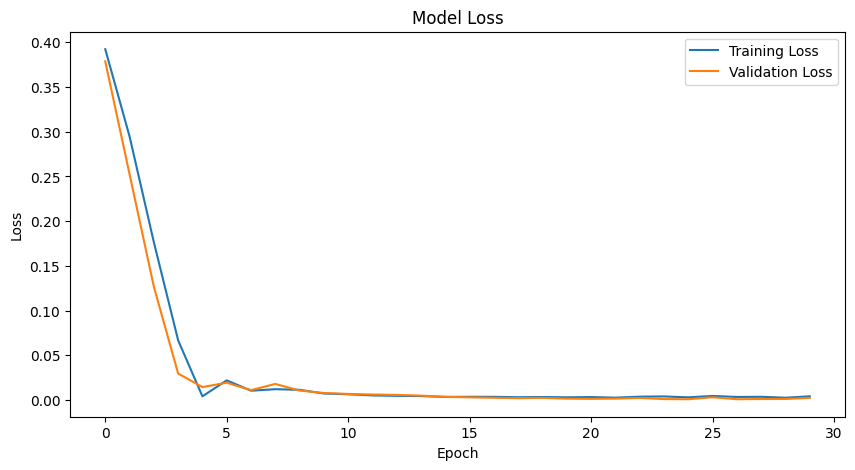

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_ntt.history['loss'], label='Training Loss')
plt.plot(history_ntt.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
forecast_ntt

Year  Forecasted_Consumption
0  2023             1212.077881
1  2024             1259.813477
2  2025             1325.199463
3  2026             1406.494141
4  2027             1474.423462
5  2028             1556.836792
6  2029             1646.239014
7  2030             1733.976929

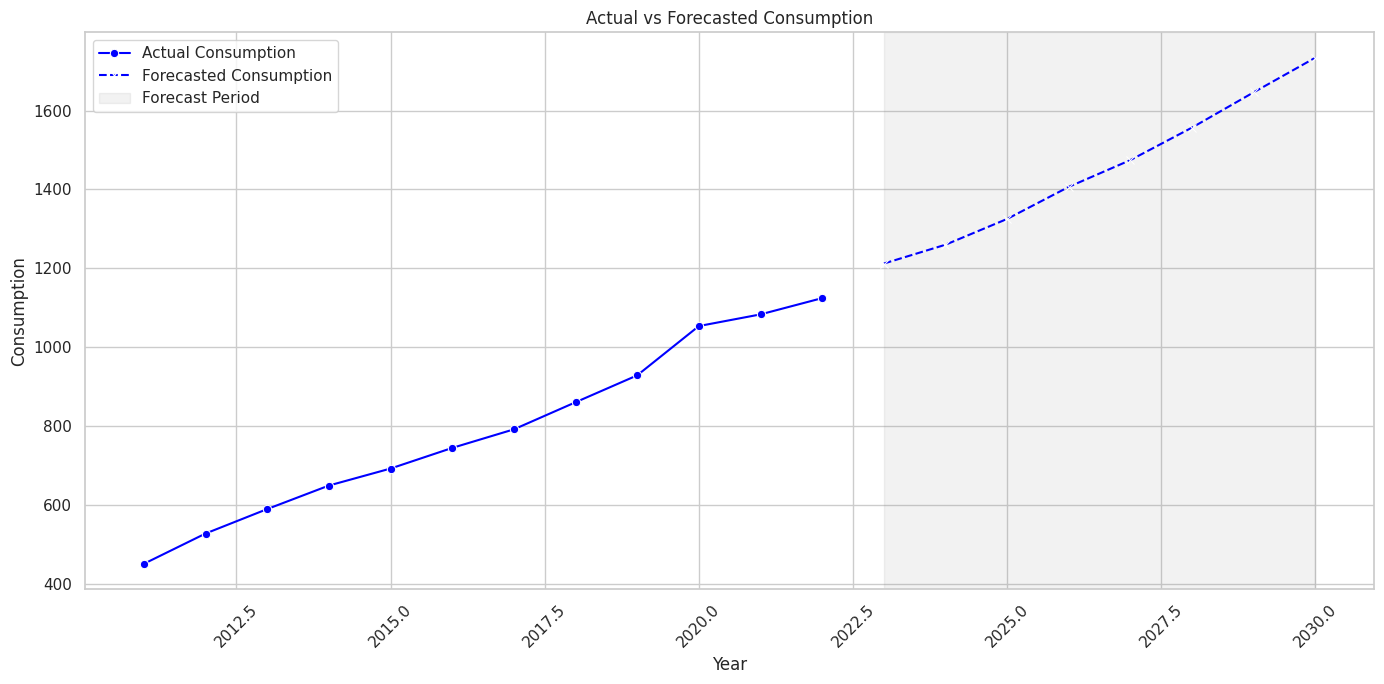

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure with the specified size
plt.figure(figsize=(14, 7))

# Plot actual consumption data
sns.lineplot(x=ntt_data['Date'], y=ntt_data['Consumption'], label='Actual Consumption', color='blue', marker='o')

# Plot forecasted consumption data with dashed line
sns.lineplot(x=forecast_ntt['Year'], y=forecast_ntt['Forecasted_Consumption'], label='Forecasted Consumption', color='blue', linestyle='--', marker='x')

# Add shading to indicate the forecast period
plt.axvspan(forecast_years[0], forecast_years[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot with title, labels, and grid
plt.title('Actual vs Forecasted Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Adjust layout for better display
plt.tight_layout()

# Show plot
plt.show()


## Sumatera Utara

In [ ]:
# Step 1: Filter data for Sumut (Sumatera Utara)
sumut_data_combined = data[data['Provinsi'] == 'Sumatera Utara'].iloc[0, 1:]

# Step 2: Create DataFrame with 'Year' and 'Consumption' columns
sumut_data_combined_df = pd.DataFrame({
    'Year': sumut_data_combined.index,
    'Consumption': sumut_data_combined.values
})

# Step 3: Convert 'Year' to 'Date' format (yyyy-mm-dd) and rearrange columns
sumut_data_combined_df['Date'] = sumut_data_combined_df['Year']
sumut_data = sumut_data_combined_df[['Date', 'Consumption']]

# Display the final combined table for Sumut
sumut_data


Date   Consumption
0   2011   6665.988198
1   2012    7266.57226
2   2013   7302.070452
3   2014   7649.030048
4   2015   8039.579979
5   2016   8526.988358
6   2017   8954.823332
7   2018   9691.934058
8   2019   7735.459912
9   2020   10404.87336
10  2021   10969.48108
11  2022  11236.124977

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Extract consumption data and prepare it for LSTM
data_values = sumut_data['Consumption'].values
data_values = data_values.reshape(-1, 1)

# Scale the data to be between 0 and 1 for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

# Prepare data for LSTM with a look-back period (using the last 3 years to predict the next)
look_back = 3
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back])
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with validation data and verbose=1 to display epoch information
history_sumut = model.fit(X_train, y_train, epochs=30, batch_size=1, validation_data=(X_val, y_val), verbose=1)

# Forecasting the next 8 years
forecast_steps = 8
forecast_input = data_scaled[-look_back:].reshape(1, look_back, 1)
forecast = []

for _ in range(forecast_steps):
    predicted = model.predict(forecast_input, verbose=0)
    forecast.append(predicted[0, 0])
    # Reshape the prediction to match the input shape
    predicted = predicted.reshape((1, 1, 1))
    forecast_input = np.append(forecast_input[:, 1:, :], predicted, axis=1)

# Rescale the forecasted values back to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
# Convert the 'Date' column to integers
sumut_data['Date'] = sumut_data['Date'].astype(int)

# Generate the forecast years based on the last year in the data
forecast_years = np.arange(sumut_data['Date'].iloc[-1] + 1, sumut_data['Date'].iloc[-1] + 1 + forecast_steps)
forecast_sumut = pd.DataFrame({'Year': forecast_years, 'Forecasted_Consumption': forecast})


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.3946 - val_loss: 0.3864
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3521 - val_loss: 0.2939
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3237 - val_loss: 0.1842
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2089 - val_loss: 0.0875
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0481 - val_loss: 0.0442
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0718 - val_loss: 0.0295
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0696 - val_loss: 0.0308
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0512 - val_loss: 0.0356
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0272 - val_loss: 0.0440
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0230 - val_loss: 0.0409
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0266 - val_loss: 0.0337
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0451 - val_loss: 0.0307
Epoch 13/30
7/7 ━━━━━

<ipython-input-97-76ad3247770d>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sumut_data['Date'] = sumut_data['Date'].astype(int)


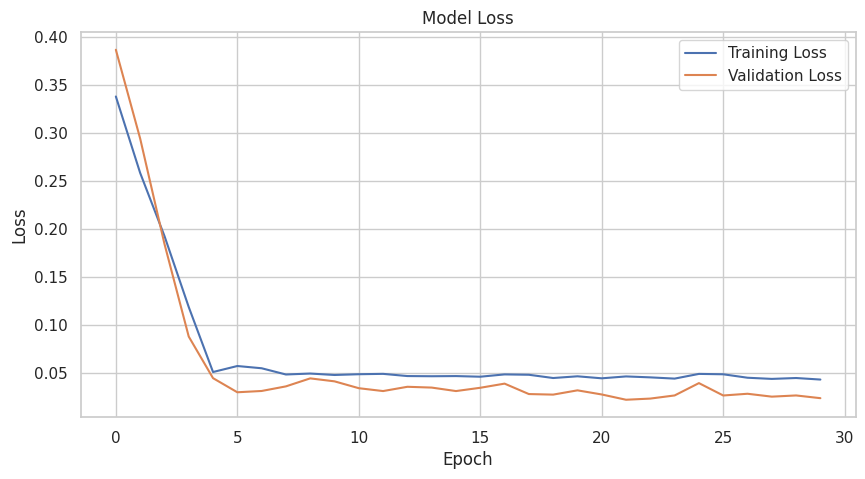

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_sumut.history['loss'], label='Training Loss')
plt.plot(history_sumut.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
forecast_sumut

Year  Forecasted_Consumption
0  2023            11695.479492
1  2024            12189.539062
2  2025            12601.283203
3  2026            13125.524414
4  2027            13663.052734
5  2028            14200.097656
6  2029            14807.295898
7  2030            15431.076172

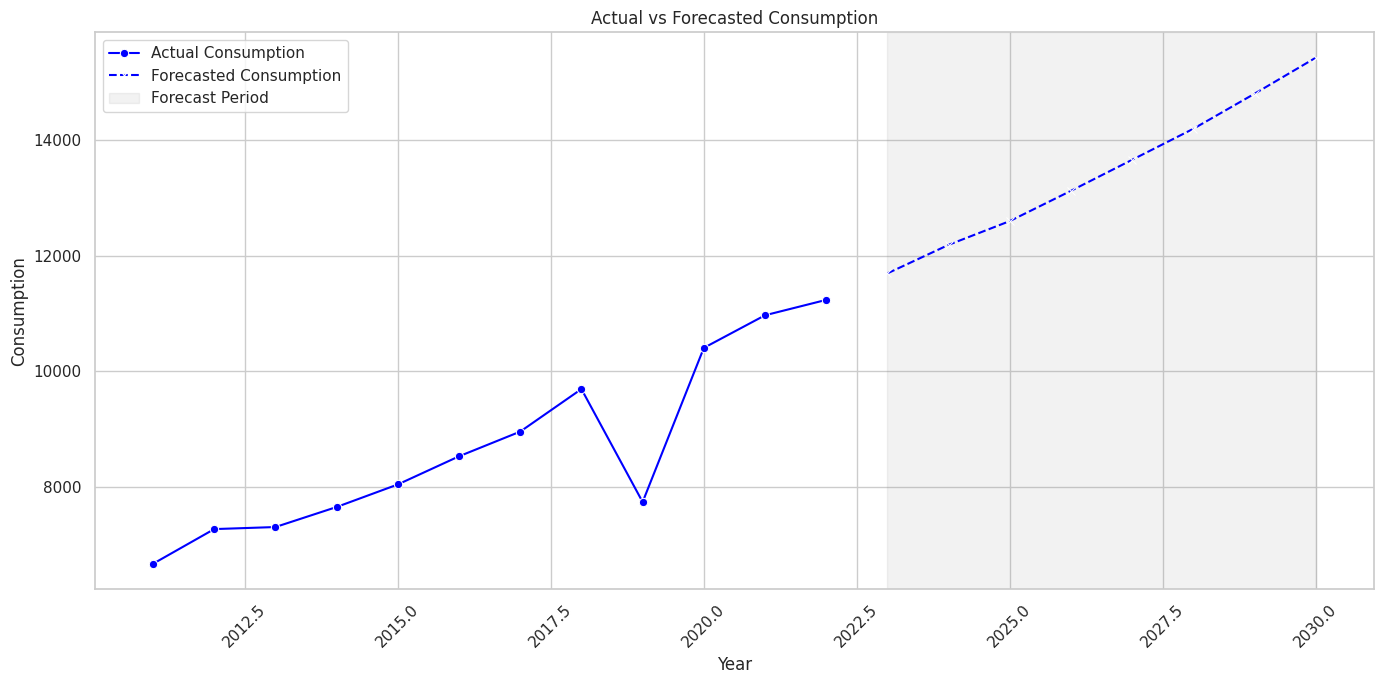

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure with the specified size
plt.figure(figsize=(14, 7))

# Plot actual consumption data
sns.lineplot(x=sumut_data['Date'], y=sumut_data['Consumption'], label='Actual Consumption', color='blue', marker='o')

# Plot forecasted consumption data with dashed line
sns.lineplot(x=forecast_sumut['Year'], y=forecast_sumut['Forecasted_Consumption'], label='Forecasted Consumption', color='blue', linestyle='--', marker='x')

# Add shading to indicate the forecast period
plt.axvspan(forecast_years[0], forecast_years[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot with title, labels, and grid
plt.title('Actual vs Forecasted Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Adjust layout for better display
plt.tight_layout()

# Show plot
plt.show()


## Papua

In [ ]:
# Step 1: Filter data for Papua
papua_data_combined = data[data['Provinsi'] == 'Papua'].iloc[0, 1:]

# Step 2: Create DataFrame with 'Year' and 'Consumption' columns
papua_data_combined_df = pd.DataFrame({
    'Year': papua_data_combined.index,
    'Consumption': papua_data_combined.values
})

# Step 3: Convert 'Year' to 'Date' format (yyyy-mm-dd) and rearrange columns
papua_data_combined_df['Date'] = papua_data_combined_df['Year']
papua_data = papua_data_combined_df[['Date', 'Consumption']]

# Display the final combined table for Papua
papua_data


Date  Consumption
0   2011    484.42648
1   2012   558.923435
2   2013   657.839698
3   2014   670.276544
4   2015   705.078684
5   2016   757.018686
6   2017   803.690459
7   2018   850.847184
8   2019    982.76838
9   2020   1052.67904
10  2021  1155.584468
11  2022  1193.060484

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Extract consumption data and prepare it for LSTM
data_values = papua_data['Consumption'].values
data_values = data_values.reshape(-1, 1)

# Scale the data to be between 0 and 1 for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

# Prepare data for LSTM with a look-back period (using the last 3 years to predict the next)
look_back = 3
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back])
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with validation data and verbose=1 to display epoch information
history_papua = model.fit(X_train, y_train, epochs=30, batch_size=1, validation_data=(X_val, y_val), verbose=1)

# Forecasting the next 8 years
forecast_steps = 8
forecast_input = data_scaled[-look_back:].reshape(1, look_back, 1)
forecast = []

for _ in range(forecast_steps):
    predicted = model.predict(forecast_input, verbose=0)
    forecast.append(predicted[0, 0])
    # Reshape the prediction to match the input shape
    predicted = predicted.reshape((1, 1, 1))
    forecast_input = np.append(forecast_input[:, 1:, :], predicted, axis=1)

# Rescale the forecasted values back to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
# Convert the 'Date' column to integers
papua_data['Date'] = papua_data['Date'].astype(int)

# Generate the forecast years based on the last year in the data
forecast_years = np.arange(papua_data['Date'].iloc[-1] + 1, papua_data['Date'].iloc[-1] + 1 + forecast_steps)
forecast_papua = pd.DataFrame({'Year': forecast_years, 'Forecasted_Consumption': forecast})


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.3521 - val_loss: 0.3742
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3176 - val_loss: 0.2638
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1785 - val_loss: 0.1481
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0876 - val_loss: 0.0506
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0243
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0248 - val_loss: 0.0249
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - val_loss: 0.0222
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0290
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - val_loss: 0.0257
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - val_loss: 0.0196
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0170
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - val_loss: 0.0147
Epoch 13/30
7/7 ━━━━━

<ipython-input-102-ce78c3d0eb28>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  papua_data['Date'] = papua_data['Date'].astype(int)


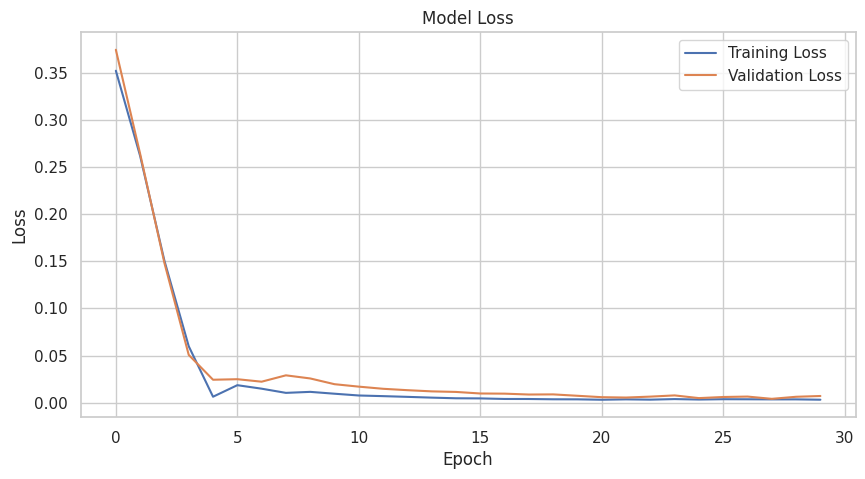

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_papua.history['loss'], label='Training Loss')
plt.plot(history_papua.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
forecast_papua

Year  Forecasted_Consumption
0  2023             1306.600342
1  2024             1416.777832
2  2025             1517.173828
3  2026             1670.340942
4  2027             1829.222290
5  2028             2005.760986
6  2029             2223.148193
7  2030             2450.538330

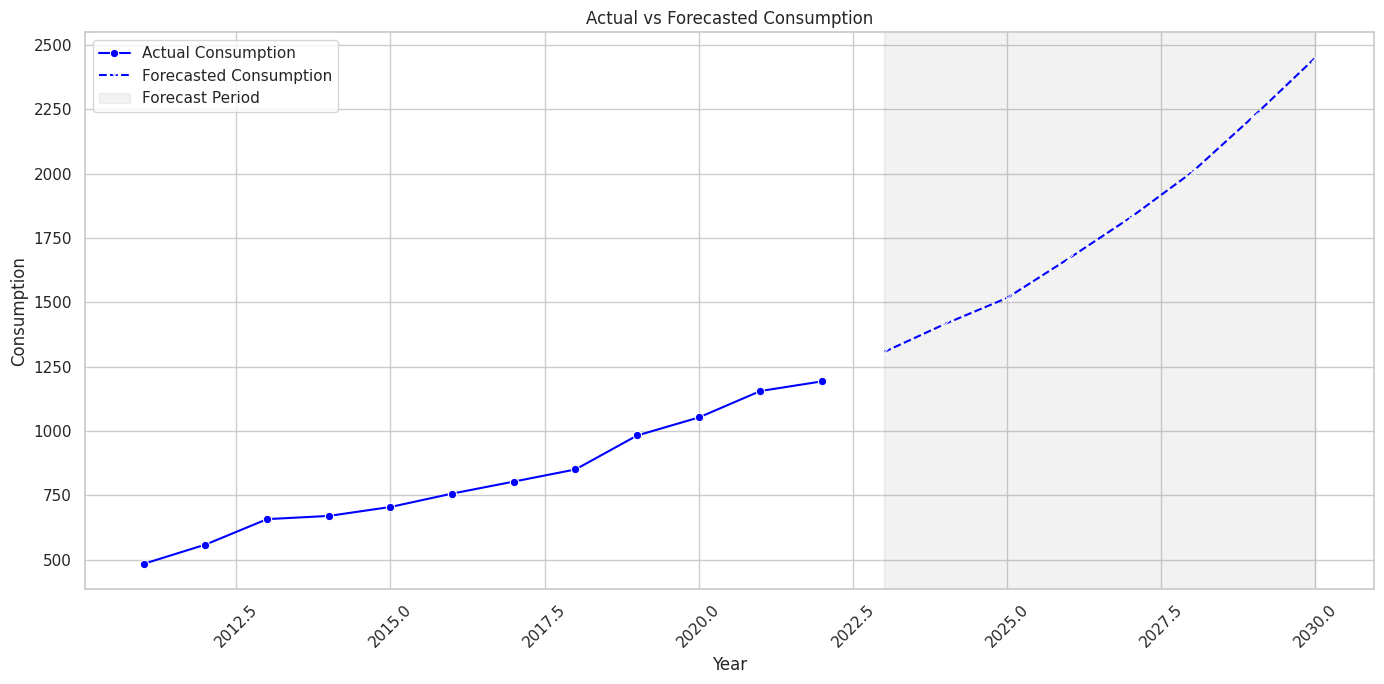

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure with the specified size
plt.figure(figsize=(14, 7))

# Plot actual consumption data
sns.lineplot(x=papua_data['Date'], y=papua_data['Consumption'], label='Actual Consumption', color='blue', marker='o')

# Plot forecasted consumption data with dashed line
sns.lineplot(x=forecast_papua['Year'], y=forecast_papua['Forecasted_Consumption'], label='Forecasted Consumption', color='blue', linestyle='--', marker='x')

# Add shading to indicate the forecast period
plt.axvspan(forecast_years[0], forecast_years[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot with title, labels, and grid
plt.title('Actual vs Forecasted Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Adjust layout for better display
plt.tight_layout()

# Show plot
plt.show()


## Kalimantan Barat

In [ ]:
# Step 1: Filter data for Kalbar (Kalimantan Barat)
kalbar_data_combined = data[data['Provinsi'] == 'Kalimantan Barat'].iloc[0, 1:]

# Step 2: Create DataFrame with 'Year' and 'Consumption' columns
kalbar_data_combined_df = pd.DataFrame({
    'Year': kalbar_data_combined.index,
    'Consumption': kalbar_data_combined.values
})

# Step 3: Convert 'Year' to 'Date' format (yyyy-mm-dd) and rearrange columns
kalbar_data_combined_df['Date'] = kalbar_data_combined_df['Year']
kalbar_data = kalbar_data_combined_df[['Date', 'Consumption']]

# Display the final combined table for Kalbar
kalbar_data


Date  Consumption
0   2011  1329.411552
1   2012   1492.26146
2   2013  1742.584397
3   2014  1722.384512
4   2015  1837.821231
5   2016  1968.356245
6   2017  2085.182354
7   2018  2202.018048
8   2019  2390.543548
9   2020  2524.486832
10  2021  2719.849426
11  2022  2827.569745

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Extract consumption data and prepare it for LSTM
data_values = kalbar_data['Consumption'].values
data_values = data_values.reshape(-1, 1)

# Scale the data to be between 0 and 1 for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

# Prepare data for LSTM with a look-back period (using the last 3 years to predict the next)
look_back = 3
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back])
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with validation data and verbose=1 to display epoch information
history_kalbar = model.fit(X_train, y_train, epochs=30, batch_size=1, validation_data=(X_val, y_val), verbose=1)

# Forecasting the next 8 years
forecast_steps = 8
forecast_input = data_scaled[-look_back:].reshape(1, look_back, 1)
forecast = []

for _ in range(forecast_steps):
    predicted = model.predict(forecast_input, verbose=0)
    forecast.append(predicted[0, 0])
    # Reshape the prediction to match the input shape
    predicted = predicted.reshape((1, 1, 1))
    forecast_input = np.append(forecast_input[:, 1:, :], predicted, axis=1)

# Rescale the forecasted values back to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
# Convert the 'Date' column to integers
kalbar_data['Date'] = kalbar_data['Date'].astype(int)

# Generate the forecast years based on the last year in the data
forecast_years = np.arange(kalbar_data['Date'].iloc[-1] + 1, kalbar_data['Date'].iloc[-1] + 1 + forecast_steps)
forecast_kalbar = pd.DataFrame({'Year': forecast_years, 'Forecasted_Consumption': forecast})


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.3312 - val_loss: 0.3613
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2918 - val_loss: 0.2435
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1138 - val_loss: 0.1234
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0794 - val_loss: 0.0272
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0246
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0280 - val_loss: 0.0193
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - val_loss: 0.0188
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - val_loss: 0.0150
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0120
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0099
Epoch 13/30
7/7 ━━━━━━

<ipython-input-107-2031257f936b>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kalbar_data['Date'] = kalbar_data['Date'].astype(int)


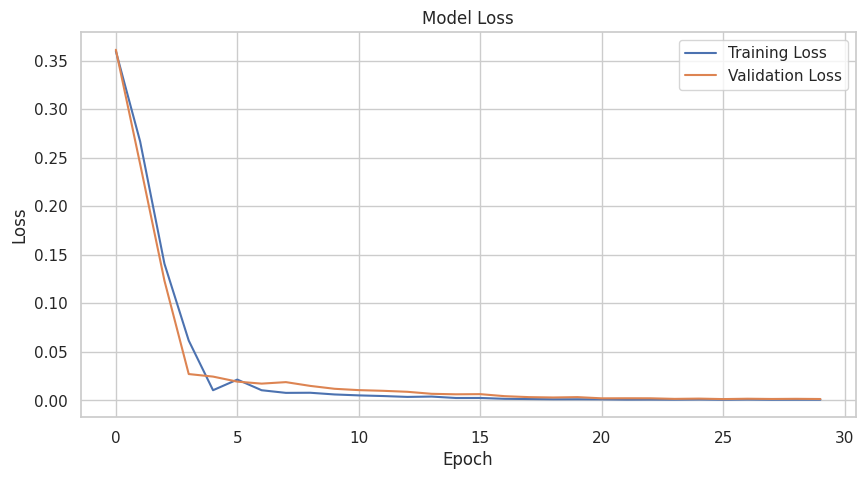

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_kalbar.history['loss'], label='Training Loss')
plt.plot(history_kalbar.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
forecast_kalbar

Year  Forecasted_Consumption
0  2023             3064.306152
1  2024             3295.956787
2  2025             3529.723389
3  2026             3861.482422
4  2027             4217.221680
5  2028             4627.614746
6  2029             5129.571289
7  2030             5674.183594

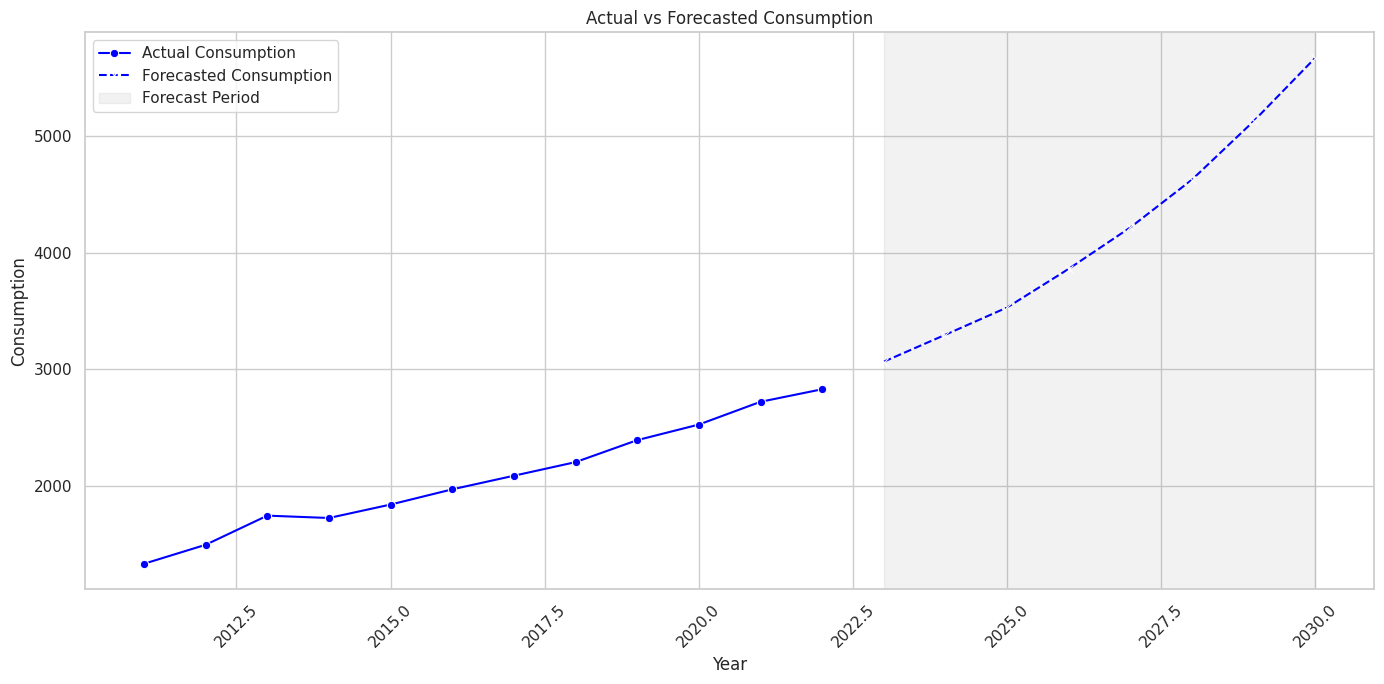

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure with the specified size
plt.figure(figsize=(14, 7))

# Plot actual consumption data
sns.lineplot(x=kalbar_data['Date'], y=kalbar_data['Consumption'], label='Actual Consumption', color='blue', marker='o')

# Plot forecasted consumption data with dashed line
sns.lineplot(x=forecast_kalbar['Year'], y=forecast_kalbar['Forecasted_Consumption'], label='Forecasted Consumption', color='blue', linestyle='--', marker='x')

# Add shading to indicate the forecast period
plt.axvspan(forecast_years[0], forecast_years[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot with title, labels, and grid
plt.title('Actual vs Forecasted Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Adjust layout for better display
plt.tight_layout()

# Show plot
plt.show()


## Maluku

In [ ]:
# Step 1: Filter data for Maluku
maluku_data_combined = data[data['Provinsi'] == 'Maluku'].iloc[0, 1:]

# Step 2: Create DataFrame with 'Year' and 'Consumption' columns
maluku_data_combined_df = pd.DataFrame({
    'Year': maluku_data_combined.index,
    'Consumption': maluku_data_combined.values
})

# Step 3: Convert 'Year' to 'Date' format (yyyy-mm-dd) and rearrange columns
maluku_data_combined_df['Date'] = maluku_data_combined_df['Year']
maluku_data = maluku_data_combined_df[['Date', 'Consumption']]

# Display the final combined table for Maluku
maluku_data


Date Consumption
0   2011  311.976954
1   2012  369.864445
2   2013  433.444108
3   2014  443.977984
4   2015  470.634387
5   2016  451.316468
6   2017  428.737995
7   2018  554.299623
8   2019  482.375596
9   2020  509.532352
10  2021  544.235056
11  2022   565.63507

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Extract consumption data and prepare it for LSTM
data_values = maluku_data['Consumption'].values
data_values = data_values.reshape(-1, 1)

# Scale the data to be between 0 and 1 for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

# Prepare data for LSTM with a look-back period (using the last 3 years to predict the next)
look_back = 3
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back])
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with validation data and verbose=1 to display epoch information
history_maluku = model.fit(X_train, y_train, epochs=30, batch_size=1, validation_data=(X_val, y_val), verbose=1)

# Forecasting the next 8 years
forecast_steps = 8
forecast_input = data_scaled[-look_back:].reshape(1, look_back, 1)
forecast = []

for _ in range(forecast_steps):
    predicted = model.predict(forecast_input, verbose=0)
    forecast.append(predicted[0, 0])
    # Reshape the prediction to match the input shape
    predicted = predicted.reshape((1, 1, 1))
    forecast_input = np.append(forecast_input[:, 1:, :], predicted, axis=1)

# Rescale the forecasted values back to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
# Convert the 'Date' column to integers
maluku_data['Date'] = maluku_data['Date'].astype(int)

# Generate the forecast years based on the last year in the data
forecast_years = np.arange(maluku_data['Date'].iloc[-1] + 1, maluku_data['Date'].iloc[-1] + 1 + forecast_steps)
forecast_maluku = pd.DataFrame({'Year': forecast_years, 'Forecasted_Consumption': forecast})


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4319 - val_loss: 0.3890
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4266 - val_loss: 0.2083
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2262 - val_loss: 0.0553
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 - val_loss: 0.0012
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0440 - val_loss: 0.0150
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0583 - val_loss: 0.0021
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199 - val_loss: 0.0014
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 - val_loss: 0.0062
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0263 - val_loss: 0.0040
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0308 - val_loss: 0.0016
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152 - val_loss: 8.5571e-04
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0235 - val_loss: 0.0011
Epoch 13/30
7/7 ━

<ipython-input-112-a2cdbf1408d1>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maluku_data['Date'] = maluku_data['Date'].astype(int)


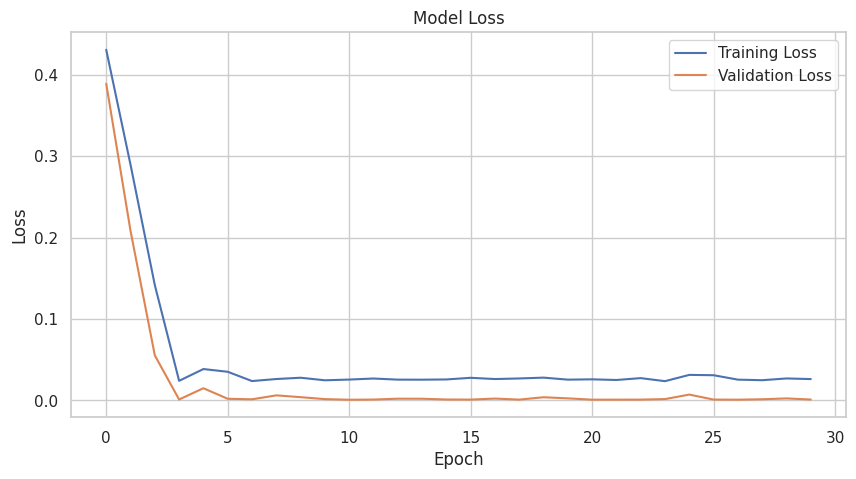

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_maluku.history['loss'], label='Training Loss')
plt.plot(history_maluku.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
forecast_maluku

Year  Forecasted_Consumption
0  2023              553.816162
1  2024              571.085632
2  2025              578.458008
3  2026              579.576721
4  2027              588.348450
5  2028              592.689880
6  2029              596.083191
7  2030              601.111755

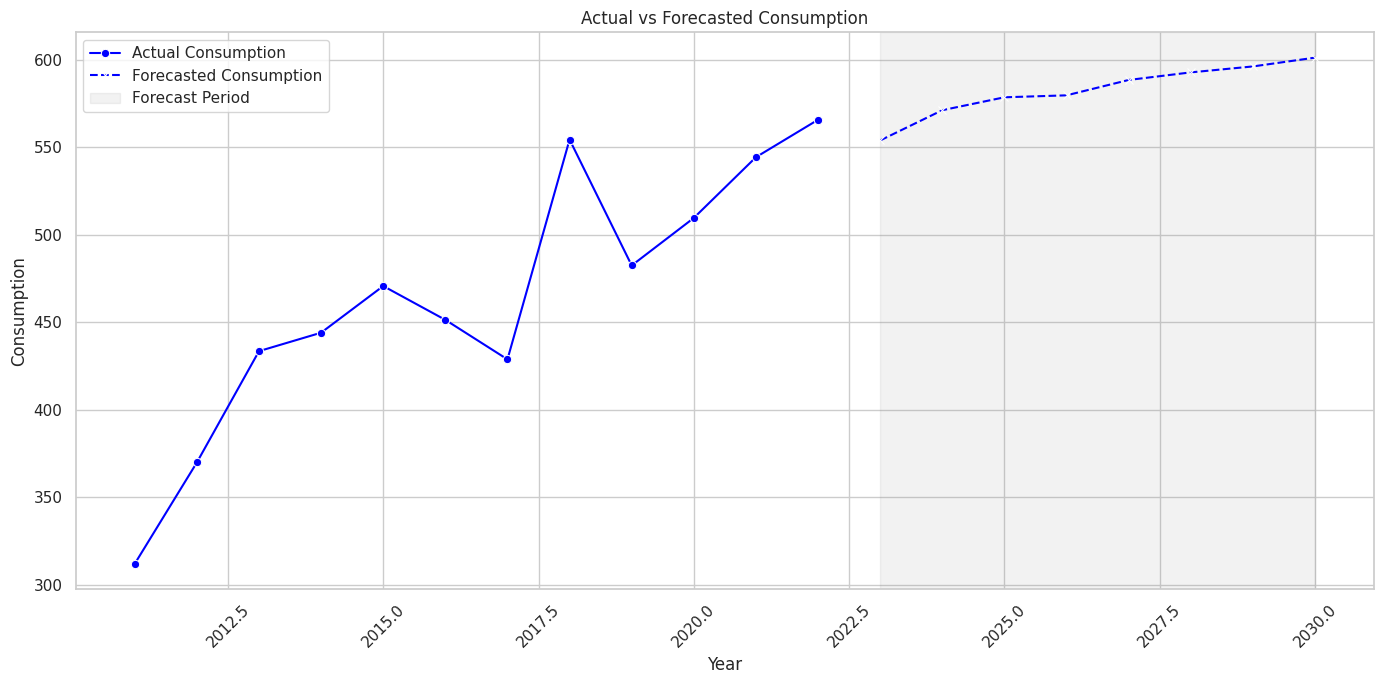

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure with the specified size
plt.figure(figsize=(14, 7))

# Plot actual consumption data
sns.lineplot(x=maluku_data['Date'], y=maluku_data['Consumption'], label='Actual Consumption', color='blue', marker='o')

# Plot forecasted consumption data with dashed line
sns.lineplot(x=forecast_maluku['Year'], y=forecast_maluku['Forecasted_Consumption'], label='Forecasted Consumption', color='blue', linestyle='--', marker='x')

# Add shading to indicate the forecast period
plt.axvspan(forecast_years[0], forecast_years[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot with title, labels, and grid
plt.title('Actual vs Forecasted Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Adjust layout for better display
plt.tight_layout()

# Show plot
plt.show()


# MAU FINAL

Data rata-rata konsumsi listrik rumah tangga pertahun
* Kalimantan: 1489 KWh
* Maluku: 1291
* Papua: 1670
* Sumut: 1522
* NTT: 801.61 - 802



In [ ]:
# Menghitung Kebutuhan Listrik Rumah Tangga MWh/Tahun

papua_rt = (206140.0572*1670)*0.000001
ntt_rt = (60700.7763*802)*0.000001
kalbar_rt = (38371.8210*1489)*0.000001
sumut_rt = (206140.0572*1522)*0.000001
maluku_rt = (14103.6532*1291)*0.000001

In [ ]:
# #  Mengonversi Kebutuhan Listrik ke MW

# papua_mw = papua_rt/(365*5)
# ntt_mw = ntt_rt/(365*5)
# kalbar_mw = kalbar_rt/(365*5)
# sumut_mw = sumut_rt/(365*5)
# maluku_mw = maluku_rt/(365*5)

## Kalbar

Data prediksi solar (KWh)

In [ ]:
kalbar_final = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/final kak/energi_kalbar.csv.crdownload')
# kalbar_final['Energi (MW)'] = kalbar_final['Energi'] * 0.001
kalbar_final = kalbar_final.rename(columns={'Tahun': 'Year'})
kalbar_final = kalbar_final.rename(columns={'Energi': 'Energi KWh'})
kalbar_final

Year  Energi KWh
0  2023   56.065223
1  2024   55.842862
2  2025   55.651637
3  2026   55.463914
4  2027   55.336949
5  2028   55.259460
6  2029   55.213879
7  2030   55.187609

Data prediksi elektrifikasi (GWh)

In [ ]:
# forecast_kalbar['Forecasted_Consumption (MW)'] = forecast_kalbar['Forecasted_Consumption'] * 1000
forecast_kalbar = forecast_kalbar.rename(columns={'Forecasted_Consumption': 'Konsumsi GWh'})
forecast_kalbar

Year  Konsumsi GWh
0  2023   3064.306152
1  2024   3295.956787
2  2025   3529.723389
3  2026   3861.482422
4  2027   4217.221680
5  2028   4627.614746
6  2029   5129.571289
7  2030   5674.183594

In [ ]:
hasil_kalbar = pd.merge(kalbar_final, forecast_kalbar, on='Year', how='inner')
hasil_kalbar['Energi GWh'] = (hasil_kalbar['Energi KWh']*0.000001)

# Display the merged DataFrame
hasil_kalbar

Year  Energi KWh  Konsumsi GWh  Energi GWh
0  2023   56.065223   3064.306152    0.000056
1  2024   55.842862   3295.956787    0.000056
2  2025   55.651637   3529.723389    0.000056
3  2026   55.463914   3861.482422    0.000055
4  2027   55.336949   4217.221680    0.000055
5  2028   55.259460   4627.614746    0.000055
6  2029   55.213879   5129.571289    0.000055
7  2030   55.187609   5674.183594    0.000055

In [ ]:
hasil_kalbar['Rasio'] = (kalbar_rt/hasil_kalbar['Konsumsi GWh'])*100
hasil_kalbar

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio
0  2023   56.065223   3064.306152    0.000056  1.864554
1  2024   55.842862   3295.956787    0.000056  1.733507
2  2025   55.651637   3529.723389    0.000056  1.618700
3  2026   55.463914   3861.482422    0.000055  1.479630
4  2027   55.336949   4217.221680    0.000055  1.354817
5  2028   55.259460   4627.614746    0.000055  1.234667
6  2029   55.213879   5129.571289    0.000055  1.113848
7  2030   55.187609   5674.183594    0.000055  1.006940

In [ ]:
# hasil_kalbar['Persentase'] = (hasil_kalbar['Energi GWh']/hasil_kalbar['Konsumsi GWh']) * 100
# print(hasil_kalbar)
hasil_kalbar['PAKAI INI (Konsumsi GWh)']=(hasil_kalbar['Rasio']*hasil_kalbar['Konsumsi GWh']/100)
hasil_kalbar['Luas m^2'] = ((hasil_kalbar['Rasio']*hasil_kalbar['Konsumsi GWh'])/100)/hasil_kalbar['Energi GWh']
hasil_kalbar

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio  \
0  2023   56.065223   3064.306152    0.000056  1.864554   
1  2024   55.842862   3295.956787    0.000056  1.733507   
2  2025   55.651637   3529.723389    0.000056  1.618700   
3  2026   55.463914   3861.482422    0.000055  1.479630   
4  2027   55.336949   4217.221680    0.000055  1.354817   
5  2028   55.259460   4627.614746    0.000055  1.234667   
6  2029   55.213879   5129.571289    0.000055  1.113848   
7  2030   55.187609   5674.183594    0.000055  1.006940   

   PAKAI INI (Konsumsi GWh)      Luas m^2  
0                 57.135639  1.019092e+06  
1                 57.135643  1.023150e+06  
2                 57.135639  1.026666e+06  
3                 57.135643  1.030141e+06  
4                 57.135643  1.032504e+06  
5                 57.135639  1.033952e+06  
6                 57.135643  1.034806e+06  
7                 57.135639  1.035298e+06

## NTT

Data prediksi solar (KWh)

In [ ]:
ntt_final = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/final kak/energi_ntt.csv.crdownload')
# ntt_final['Energi (MW)'] = ntt_final['Energi'] * 0.001
ntt_final = ntt_final.rename(columns={'Tahun': 'Year'})
ntt_final = ntt_final.rename(columns={'Energi': 'Energi KWh'})
ntt_final

Year  Energi KWh
0  2023   58.545075
1  2024   62.271688
2  2025   64.968123
3  2026   66.872744
4  2027   68.153987
5  2028   68.922692
6  2029   69.287853
7  2030   69.365423

Data prediksi elektrifikasi (GWh)

In [ ]:
# forecast_ntt['Forecasted_Consumption (MW)'] = forecast_ntt['Forecasted_Consumption'] * 1000
forecast_ntt = forecast_ntt.rename(columns={'Forecasted_Consumption': 'Konsumsi GWh'})
forecast_ntt

Year  Konsumsi GWh
0  2023   1212.077881
1  2024   1259.813477
2  2025   1325.199463
3  2026   1406.494141
4  2027   1474.423462
5  2028   1556.836792
6  2029   1646.239014
7  2030   1733.976929

In [ ]:
hasil_ntt = pd.merge(ntt_final, forecast_ntt, on='Year', how='inner')
hasil_ntt['Energi GWh'] = (hasil_ntt['Energi KWh']*0.000001)

# Display the merged DataFrame
hasil_ntt

Year  Energi KWh  Konsumsi GWh  Energi GWh
0  2023   58.545075   1212.077881    0.000059
1  2024   62.271688   1259.813477    0.000062
2  2025   64.968123   1325.199463    0.000065
3  2026   66.872744   1406.494141    0.000067
4  2027   68.153987   1474.423462    0.000068
5  2028   68.922692   1556.836792    0.000069
6  2029   69.287853   1646.239014    0.000069
7  2030   69.365423   1733.976929    0.000069

In [ ]:
hasil_ntt['Rasio'] = (ntt_rt/hasil_ntt['Konsumsi GWh'])*100
hasil_ntt

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio
0  2023   58.545075   1212.077881    0.000059  4.016410
1  2024   62.271688   1259.813477    0.000062  3.864225
2  2025   64.968123   1325.199463    0.000065  3.673562
3  2026   66.872744   1406.494141    0.000067  3.461232
4  2027   68.153987   1474.423462    0.000068  3.301766
5  2028   68.922692   1556.836792    0.000069  3.126983
6  2029   69.287853   1646.239014    0.000069  2.957166
7  2030   69.365423   1733.976929    0.000069  2.807536

In [ ]:
# hasil_ntt['Persentase'] = (hasil_ntt['Energi GWh']/hasil_ntt['Konsumsi GWh']) * 100
# print(hasil_ntt)
hasil_ntt['PAKAI INI (Konsumsi GWh)']=(hasil_ntt['Rasio']*hasil_ntt['Konsumsi GWh']/100)
hasil_ntt['Luas m^2'] = ((hasil_ntt['Rasio']*hasil_ntt['Konsumsi GWh'])/100)/hasil_ntt['Energi GWh']
hasil_ntt

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio  \
0  2023   58.545075   1212.077881    0.000059  4.016410   
1  2024   62.271688   1259.813477    0.000062  3.864225   
2  2025   64.968123   1325.199463    0.000065  3.673562   
3  2026   66.872744   1406.494141    0.000067  3.461232   
4  2027   68.153987   1474.423462    0.000068  3.301766   
5  2028   68.922692   1556.836792    0.000069  3.126983   
6  2029   69.287853   1646.239014    0.000069  2.957166   
7  2030   69.365423   1733.976929    0.000069  2.807536   

   PAKAI INI (Konsumsi GWh)       Luas m^2  
0                 48.682022  831530.612024  
1                 48.682022  781768.146495  
2                 48.682026  749321.718633  
3                 48.682022  727980.029065  
4                 48.682018  714294.503848  
5                 48.682022  706327.926602  
6                 48.682022  702605.432520  
7                 48.682026  701819.782775

## Sumut

Data prediksi solar (KWh)

In [ ]:
sumut_final = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/final kak/energi_sumut.csv.crdownload')
# sumut_final['Energi (MW)'] = sumut_final['Energi'] * 0.001
sumut_final = sumut_final.rename(columns={'Tahun': 'Year'})
sumut_final = sumut_final.rename(columns={'Energi': 'Energi KWh'})
sumut_final

Year  Energi KWh
0  2023   50.817862
1  2024   52.173917
2  2025   52.649853
3  2026   52.869328
4  2027   52.944816
5  2028   52.976106
6  2029   52.987602
7  2030   52.992033

Data prediksi elektrifikasi (GWh)

In [ ]:
# forecast_kalbar['Forecasted_Consumption (MW)'] = forecast_sumut['Forecasted_Consumption'] * 1000
forecast_sumut = forecast_sumut.rename(columns={'Forecasted_Consumption': 'Konsumsi GWh'})
forecast_sumut

Year  Konsumsi GWh
0  2023  11695.479492
1  2024  12189.539062
2  2025  12601.283203
3  2026  13125.524414
4  2027  13663.052734
5  2028  14200.097656
6  2029  14807.295898
7  2030  15431.076172

In [ ]:
hasil_sumut = pd.merge(sumut_final, forecast_sumut, on='Year', how='inner')
hasil_sumut['Energi GWh'] = (hasil_sumut['Energi KWh']*0.000001)

# Display the merged DataFrame
hasil_sumut

Year  Energi KWh  Konsumsi GWh  Energi GWh
0  2023   50.817862  11695.479492    0.000051
1  2024   52.173917  12189.539062    0.000052
2  2025   52.649853  12601.283203    0.000053
3  2026   52.869328  13125.524414    0.000053
4  2027   52.944816  13663.052734    0.000053
5  2028   52.976106  14200.097656    0.000053
6  2029   52.987602  14807.295898    0.000053
7  2030   52.992033  15431.076172    0.000053

In [ ]:
hasil_sumut['Rasio'] = (sumut_rt/hasil_sumut['Konsumsi GWh'])*100
hasil_sumut

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio
0  2023   50.817862  11695.479492    0.000051  2.682619
1  2024   52.173917  12189.539062    0.000052  2.573889
2  2025   52.649853  12601.283203    0.000053  2.489788
3  2026   52.869328  13125.524414    0.000053  2.390344
4  2027   52.944816  13663.052734    0.000053  2.296304
5  2028   52.976106  14200.097656    0.000053  2.209458
6  2029   52.987602  14807.295898    0.000053  2.118855
7  2030   52.992033  15431.076172    0.000053  2.033203

In [ ]:
# hasil_sumut['Persentase'] = (hasil_sumut['Energi GWh']/hasil_sumut['Konsumsi GWh']) * 100
# print(hasil_sumut)
hasil_sumut['PAKAI INI (Konsumsi GWh)']=(hasil_sumut['Rasio']*hasil_sumut['Konsumsi GWh']/100)
hasil_sumut['Luas m^2'] = ((hasil_sumut['Rasio']*hasil_sumut['Konsumsi GWh'])/100)/hasil_sumut['Energi GWh']
hasil_sumut

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio  \
0  2023   50.817862  11695.479492    0.000051  2.682619   
1  2024   52.173917  12189.539062    0.000052  2.573889   
2  2025   52.649853  12601.283203    0.000053  2.489788   
3  2026   52.869328  13125.524414    0.000053  2.390344   
4  2027   52.944816  13663.052734    0.000053  2.296304   
5  2028   52.976106  14200.097656    0.000053  2.209458   
6  2029   52.987602  14807.295898    0.000053  2.118855   
7  2030   52.992033  15431.076172    0.000053  2.033203   

   PAKAI INI (Konsumsi GWh)      Luas m^2  
0                313.745178  6.173915e+06  
1                313.745178  6.013449e+06  
2                313.745178  5.959089e+06  
3                313.745178  5.934352e+06  
4                313.745148  5.925890e+06  
5                313.745178  5.922390e+06  
6                313.745148  5.921105e+06  
7                313.745148  5.920610e+06

## Papua

Data prediksi solar (KWh)

In [ ]:
papua_final = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/final kak/energi_papua.csv.crdownload')
# papua_final['Energi (MW)'] = papua_final['Energi'] * 0.001
papua_final = papua_final.rename(columns={'Tahun': 'Year'})
papua_final = papua_final.rename(columns={'Energi': 'Energi KWh'})
papua_final

Year  Energi KWh
0  2023   52.051072
1  2024   51.688195
2  2025   51.811078
3  2026   52.072690
4  2027   52.435378
5  2028   52.849404
6  2029   53.282978
7  2030   53.711445

Data prediksi elektrifikasi (GWh)

In [ ]:
# forecast_kalbar['Forecasted_Consumption (MW)'] = forecast_papua['Forecasted_Consumption'] * 1000
forecast_papua = forecast_papua.rename(columns={'Forecasted_Consumption': 'Konsumsi GWh'})
forecast_papua

Year  Konsumsi GWh
0  2023   1306.600342
1  2024   1416.777832
2  2025   1517.173828
3  2026   1670.340942
4  2027   1829.222290
5  2028   2005.760986
6  2029   2223.148193
7  2030   2450.538330

In [ ]:
hasil_papua = pd.merge(papua_final, forecast_papua, on='Year', how='inner')
hasil_papua['Energi GWh'] = (hasil_papua['Energi KWh']*0.000001)

# Display the merged DataFrame
hasil_papua

Year  Energi KWh  Konsumsi GWh  Energi GWh
0  2023   52.051072   1306.600342    0.000052
1  2024   51.688195   1416.777832    0.000052
2  2025   51.811078   1517.173828    0.000052
3  2026   52.072690   1670.340942    0.000052
4  2027   52.435378   1829.222290    0.000052
5  2028   52.849404   2005.760986    0.000053
6  2029   53.282978   2223.148193    0.000053
7  2030   53.711445   2450.538330    0.000054

In [ ]:
hasil_papua['Rasio'] = (papua_rt/hasil_papua['Konsumsi GWh'])*100
hasil_papua

Year  Energi KWh  Konsumsi GWh  Energi GWh      Rasio
0  2023   52.051072   1306.600342    0.000052  26.347300
1  2024   51.688195   1416.777832    0.000052  24.298368
2  2025   51.811078   1517.173828    0.000052  22.690472
3  2026   52.072690   1670.340942    0.000052  20.609798
4  2027   52.435378   1829.222290    0.000052  18.819687
5  2028   52.849404   2005.760986    0.000053  17.163258
6  2029   53.282978   2223.148193    0.000053  15.484974
7  2030   53.711445   2450.538330    0.000054  14.048094

In [ ]:
# hasil_papua['Persentase'] = (hasil_papua['Energi GWh']/hasil_papua['Konsumsi GWh']) * 100
# print(hasil_papua)
hasil_papua['PAKAI INI (Konsumsi GWh)']=(hasil_papua['Rasio']*hasil_papua['Konsumsi GWh']/100)
hasil_papua['Luas m^2'] = ((hasil_papua['Rasio']*hasil_papua['Konsumsi GWh'])/100)/hasil_papua['Energi GWh']
hasil_papua

Year  Energi KWh  Konsumsi GWh  Energi GWh      Rasio  \
0  2023   52.051072   1306.600342    0.000052  26.347300   
1  2024   51.688195   1416.777832    0.000052  24.298368   
2  2025   51.811078   1517.173828    0.000052  22.690472   
3  2026   52.072690   1670.340942    0.000052  20.609798   
4  2027   52.435378   1829.222290    0.000052  18.819687   
5  2028   52.849404   2005.760986    0.000053  17.163258   
6  2029   53.282978   2223.148193    0.000053  15.484974   
7  2030   53.711445   2450.538330    0.000054  14.048094   

   PAKAI INI (Konsumsi GWh)      Luas m^2  
0                344.253906  6.613772e+06  
1                344.253906  6.660204e+06  
2                344.253906  6.644407e+06  
3                344.253906  6.611026e+06  
4                344.253906  6.565298e+06  
5                344.253906  6.513865e+06  
6                344.253906  6.460861e+06  
7                344.253906  6.409321e+06

## Maluku

Data prediksi solar (KWh)

In [ ]:
maluku_final = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/data kapasitas terpasang/final kak/energi_maluku.csv.crdownload')
# maluku_final['Energi (MW)'] = maluku_final['Energi'] * 0.001
maluku_final = maluku_final.rename(columns={'Tahun': 'Year'})
maluku_final = maluku_final.rename(columns={'Energi': 'Energi KWh'})
maluku_final

Year  Energi KWh
0  2023   56.339393
1  2024   59.018571
2  2025   60.767854
3  2026   62.053158
4  2027   62.994720
5  2028   63.717028
6  2029   64.273539
7  2030   64.701571

Data prediksi elektrifikasi (GWh)

In [ ]:
# forecast_maluku['Forecasted_Consumption (MW)'] = forecast_maluku['Forecasted_Consumption'] * 1000
forecast_maluku = forecast_maluku.rename(columns={'Forecasted_Consumption': 'Konsumsi GWh'})
forecast_maluku

Year  Konsumsi GWh
0  2023    553.816162
1  2024    571.085632
2  2025    578.458008
3  2026    579.576721
4  2027    588.348450
5  2028    592.689880
6  2029    596.083191
7  2030    601.111755

In [ ]:
hasil_maluku = pd.merge(maluku_final, forecast_maluku, on='Year', how='inner')
hasil_maluku['Energi GWh'] = (hasil_maluku['Energi KWh']*0.000001)

# Display the merged DataFrame
hasil_maluku

Year  Energi KWh  Konsumsi GWh  Energi GWh
0  2023   56.339393    553.816162    0.000056
1  2024   59.018571    571.085632    0.000059
2  2025   60.767854    578.458008    0.000061
3  2026   62.053158    579.576721    0.000062
4  2027   62.994720    588.348450    0.000063
5  2028   63.717028    592.689880    0.000064
6  2029   64.273539    596.083191    0.000064
7  2030   64.701571    601.111755    0.000065

In [ ]:
hasil_maluku['Rasio'] = (maluku_rt/hasil_maluku['Konsumsi GWh'])*100
hasil_maluku

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio
0  2023   56.339393    553.816162    0.000056  3.287701
1  2024   59.018571    571.085632    0.000059  3.188282
2  2025   60.767854    578.458008    0.000061  3.147647
3  2026   62.053158    579.576721    0.000062  3.141572
4  2027   62.994720    588.348450    0.000063  3.094733
5  2028   63.717028    592.689880    0.000064  3.072065
6  2029   64.273539    596.083191    0.000064  3.054577
7  2030   64.701571    601.111755    0.000065  3.029024

In [ ]:
# hasil_maluku['Persentase'] = (hasil_maluku['Energi GWh']/hasil_maluku['Konsumsi GWh']) * 100
# print(hasil_maluku)
hasil_maluku['PAKAI INI (Konsumsi GWh)']=(hasil_maluku['Rasio']*hasil_maluku['Konsumsi GWh']/100)
hasil_maluku['Luas m^2'] = ((hasil_maluku['Rasio']*hasil_maluku['Konsumsi GWh'])/100)/hasil_maluku['Energi GWh']
hasil_maluku

Year  Energi KWh  Konsumsi GWh  Energi GWh     Rasio  \
0  2023   56.339393    553.816162    0.000056  3.287701   
1  2024   59.018571    571.085632    0.000059  3.188282   
2  2025   60.767854    578.458008    0.000061  3.147647   
3  2026   62.053158    579.576721    0.000062  3.141572   
4  2027   62.994720    588.348450    0.000063  3.094733   
5  2028   63.717028    592.689880    0.000064  3.072065   
6  2029   64.273539    596.083191    0.000064  3.054577   
7  2030   64.701571    601.111755    0.000065  3.029024   

   PAKAI INI (Konsumsi GWh)       Luas m^2  
0                 18.207817  323180.925766  
1                 18.207817  308509.962826  
2                 18.207817  299629.095356  
3                 18.207817  293422.893472  
4                 18.207817  289037.191997  
5                 18.207817  285760.612299  
6                 18.207817  283286.364454  
7                 18.207817  281412.287727

# MERGE DATA 2030

In [ ]:
# Add a new column indicating the province in each dataframe
hasil_papua['Province'] = 'Papua'
hasil_maluku['Province'] = 'Maluku'
hasil_ntt['Province'] = 'Nusa Tenggara Timur'
hasil_sumut['Province'] = 'Sumatra Utara'
hasil_kalbar['Province'] = 'Kalimantan Barat'

# Filter for the year 2030 and drop unnecessary columns
papua_2030 = hasil_papua[hasil_papua['Year'] == 2030].drop(columns=['Rasio', 'Energi KWh', 'Konsumsi GWh'])
maluku_2030 = hasil_maluku[hasil_maluku['Year'] == 2030].drop(columns=['Rasio', 'Energi KWh', 'Konsumsi GWh'])
ntt_2030 = hasil_ntt[hasil_ntt['Year'] == 2030].drop(columns=['Rasio', 'Energi KWh', 'Konsumsi GWh'])
sumut_2030 = hasil_sumut[hasil_sumut['Year'] == 2030].drop(columns=['Rasio', 'Energi KWh', 'Konsumsi GWh'])
kalbar_2030 = hasil_kalbar[hasil_kalbar['Year'] == 2030].drop(columns=['Rasio', 'Energi KWh', 'Konsumsi GWh'])

# Concatenate the dataframes row-wise to keep the 'Province' column
merged_2030 = pd.concat([papua_2030, maluku_2030, ntt_2030, sumut_2030, kalbar_2030], ignore_index=True)

# Display the merged dataframe with the new 'Province' column
print(merged_2030)
merged_2030

   Year  Energi GWh  PAKAI INI (Konsumsi GWh)      Luas m^2  \
0  2030    0.000054                344.253906  6.409321e+06   
1  2030    0.000065                 18.207817  2.814123e+05   
2  2030    0.000069                 48.682026  7.018198e+05   
3  2030    0.000053                313.745148  5.920610e+06   
4  2030    0.000055                 57.135639  1.035298e+06   

              Province  
0                Papua  
1               Maluku  
2  Nusa Tenggara Timur  
3        Sumatra Utara  
4     Kalimantan Barat  


Year  Energi GWh  PAKAI INI (Konsumsi GWh)      Luas m^2  \
0  2030    0.000054                344.253906  6.409321e+06   
1  2030    0.000065                 18.207817  2.814123e+05   
2  2030    0.000069                 48.682026  7.018198e+05   
3  2030    0.000053                313.745148  5.920610e+06   
4  2030    0.000055                 57.135639  1.035298e+06   

              Province  
0                Papua  
1               Maluku  
2  Nusa Tenggara Timur  
3        Sumatra Utara  
4     Kalimantan Barat

In [ ]:
merged_2030 = merged_2030.drop(columns=['Year'])

In [ ]:
merged_2030

Energi GWh  PAKAI INI (Konsumsi GWh)      Luas m^2             Province
0    0.000054                344.253906  6.409321e+06                Papua
1    0.000065                 18.207817  2.814123e+05               Maluku
2    0.000069                 48.682026  7.018198e+05  Nusa Tenggara Timur
3    0.000053                313.745148  5.920610e+06        Sumatra Utara
4    0.000055                 57.135639  1.035298e+06     Kalimantan Barat

In [ ]:

merged_2030 = merged_2030.rename(columns={
    'Energi GWh': 'Energi_GWh',
    'PAKAI INI (Konsumsi GWh)': 'Konsumsi_GWh',
    'Luas m^2': 'Luas_m2'
})
merged_2030

Energi_GWh  Konsumsi_GWh       Luas_m2             Province
0    0.000054    344.253906  6.409321e+06                Papua
1    0.000065     18.207817  2.814123e+05               Maluku
2    0.000069     48.682026  7.018198e+05  Nusa Tenggara Timur
3    0.000053    313.745148  5.920610e+06        Sumatra Utara
4    0.000055     57.135639  1.035298e+06     Kalimantan Barat

In [ ]:

merged_2030_sorted = merged_2030.sort_values('Luas_m2', ascending=False)

# Display the sorted dataframe
merged_2030_sorted


Energi_GWh  Konsumsi_GWh       Luas_m2             Province
0    0.000054    344.253906  6.409321e+06                Papua
3    0.000053    313.745148  5.920610e+06        Sumatra Utara
4    0.000055     57.135639  1.035298e+06     Kalimantan Barat
2    0.000069     48.682026  7.018198e+05  Nusa Tenggara Timur
1    0.000065     18.207817  2.814123e+05               Maluku